## Efficientnet Adversarial Learning with RKD - WIDER (Class Reduced)

In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import copy
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# new libraries
from models_package.models import Teacher, Student, CustomResNet18
from torchvision import datasets, transforms, models
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof, load_wider
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss, DD_loss, AD_loss, RKDDistanceLoss, RKDAngleLoss
from utils.misc_tools_rkd import best_lr_rkd, rkd_train_teacher, rkd_train_student_with_distillation, rkd_test_model
from utils.compare_tools_rkd import compare_model_size, compare_inference_time, compare_performance_metrics, plot_comparison

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.001379 # 0.096779
epochs = 300
epochs_pretrain = 3 #3
epochs_optimal_lr = 3 #5
patience_teacher = 7
patience_student = 10
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
lmda = 3
batch_size = 64
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False # True

# list of lambda values to loop through for grid search
lmda_list_student = [0,3,5]
lmda_list_teacher = [0]
# lmda_list_teacher = [0,3,5,10]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16 #len(class_labels)
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = 'data/WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(16):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'data/WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'data/WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "data/WIDER/Image/train" in img_path:
            label_str = img_path.split("data/WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "data/WIDER/Image/test" in img_path:
            label_str = img_path.split("data/WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "data/WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("data/WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
len(train_dataset)

10324

# Start Training Process

In [12]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [13]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_rkd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_rkd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_rkd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_rkd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_rkd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [14]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [15]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [16]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [17]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [18]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [19]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [20]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [21]:
best_lr_student = learning_rate
best_lr_teacher = learning_rate

In [22]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [23]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [24]:
# Function to train the teacher model


def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_rkd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_rkd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        # if patience_counter >= patience:
        #     print('Early stopping')
        #     break  
            
        file_path = os.path.join(output_dir, f'teacher_validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Teacher Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nTeacher Val Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        # Train the adversary at the start of each epoch
        train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            # kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar

            # RKD Loss
            distance_loss = RKDDistanceLoss()(student_outputs, teacher_outputs)
            angle_loss = RKDAngleLoss()(student_outputs, teacher_outputs)
            
            if lmda != 0:
                loss = ce_loss + 0.1 * (distance_loss + angle_loss) + (ce_loss + 0.1 * (distance_loss + angle_loss))/adversary_loss - lmda * adversary_loss
            else:
                loss = ce_loss + 0.1 * (distance_loss + angle_loss)
    
            # if kd_loss.ndim != 0:
            #     kd_loss = kd_loss.sum()

            # # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # # goal of the model is to have the adversary not predict gender. 
            # if lmda != 0:
            #     loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            # else:
            #     loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studentached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                # val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
    
                # RKD Loss
                val_distance_loss = RKDDistanceLoss()(val_student_outputs, val_teacher_outputs)
                val_angle_loss = RKDAngleLoss()(val_student_outputs, val_teacher_outputs)
                if lmda != 0:
                    val_loss = \
                        val_ce_loss + 0.1 * (val_distance_loss + val_angle_loss) + (val_ce_loss + 0.1 * (val_distance_loss + val_angle_loss))/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = val_ce_loss + 0.1 * (val_distance_loss + val_angle_loss)
                
                # if val_kd_loss.ndim != 0:
                #     val_kd_loss = val_kd_loss.sum()
                # if lmda != 0:
                #     val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                # else:
                #     val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_rkd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_rkd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
    
        file_path = os.path.join(output_dir, f'validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 1/30*****
*****Train Loss:  1.672278 Val Loss:  1.427514*****
*****Validation Accuracy: 57.52%*****
*****Total Avg Disparity: 0.12452049733518733*****

Class Team_Sports: Recall Difference = 0.06977795866684744
Class Celebration: Recall Difference = 0.1271121351766512
Class Parade: Recall Difference = 0.012034137655799082
Class Waiter_Or_Waitress: Recall Difference = -0.196232339089482
Class Individual_Sports: Recall Difference = -0.07791762013729986
Class Surgeons: Recall Difference = -0.005952380952380931
Class Spa: Recall Difference = 0.1428571428571429
Class Law_Enforcement: Recall Difference = 0.16425479282622157
Class Business: Recall Difference = 0.09141156462585032
Class Dresses: Recall Difference = -0.5399038461538461
Class Water Activities: Recall Difference = 0.10799726589200298
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = -0.018231768231768253
Class Cheering: Recall Difference = 0.038761279737489746
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.94it/s]


*****Epoch 2/30*****
*****Train Loss:  1.222378 Val Loss:  1.313179*****
*****Validation Accuracy: 61.73%*****
*****Total Avg Disparity: 0.17874882255143182*****

Class Team_Sports: Recall Difference = 0.06066567177678306
Class Celebration: Recall Difference = 0.10791090629800304
Class Parade: Recall Difference = -0.06839810892122544
Class Waiter_Or_Waitress: Recall Difference = -0.13736263736263743
Class Individual_Sports: Recall Difference = -0.15442410373760507
Class Surgeons: Recall Difference = -0.10863095238095255
Class Spa: Recall Difference = -0.7551020408163265
Class Law_Enforcement: Recall Difference = 0.09165120593692022
Class Business: Recall Difference = 0.008715986394557729
Class Dresses: Recall Difference = -0.8625
Class Water Activities: Recall Difference = 0.01822738664843937
Class Picnic: Recall Difference = -0.23636363636363636
Class Rescue: Recall Difference = -0.034465534465534464
Class Cheering: Recall Difference = 0.054142739950779395
Class Performance_And_Entert

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 3/30*****
*****Train Loss:  0.983919 Val Loss:  1.349495*****
*****Validation Accuracy: 59.28%*****
*****Total Avg Disparity: 0.16173198144491974*****

Class Team_Sports: Recall Difference = 0.12271062271062261
Class Celebration: Recall Difference = -0.0741167434715822
Class Parade: Recall Difference = 0.005403082212807719
Class Waiter_Or_Waitress: Recall Difference = 0.023547880690737766
Class Individual_Sports: Recall Difference = -0.11941266209000756
Class Surgeons: Recall Difference = -0.1428571428571428
Class Spa: Recall Difference = 0.1836734693877552
Class Law_Enforcement: Recall Difference = 0.1052566481137911
Class Business: Recall Difference = 0.0848214285714286
Class Dresses: Recall Difference = -0.658653846153846
Class Water Activities: Recall Difference = 0.07017543859649134
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = 0.14010989010989017
Class Cheering: Recall Difference = 0.1253076292042658
Class Performance_And_Ente

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 4/30*****
*****Train Loss:  0.811261 Val Loss:  1.471870*****
*****Validation Accuracy: 61.39%*****
*****Total Avg Disparity: 0.12299076603202053*****

Class Team_Sports: Recall Difference = 0.06342423009089693
Class Celebration: Recall Difference = 0.02803379416282642
Class Parade: Recall Difference = -0.06084607355559646
Class Waiter_Or_Waitress: Recall Difference = -0.1703296703296705
Class Individual_Sports: Recall Difference = -0.1860030511060261
Class Surgeons: Recall Difference = -0.007440476190476164
Class Spa: Recall Difference = 0.20408163265306123
Class Law_Enforcement: Recall Difference = -0.0035868893011749003
Class Business: Recall Difference = 0.020408163265306034
Class Dresses: Recall Difference = -0.7
Class Water Activities: Recall Difference = 0.13807245386192757
Class Picnic: Recall Difference = -0.05454545454545459
Class Rescue: Recall Difference = 0.11313686313686311
Class Cheering: Recall Difference = -0.00533223954060702
Class Performance_And_Entertain

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 5/30*****
*****Train Loss:  0.664406 Val Loss:  1.447911*****
*****Validation Accuracy: 60.69%*****
*****Total Avg Disparity: 0.18745540043320522*****

Class Team_Sports: Recall Difference = 0.06758467869578966
Class Celebration: Recall Difference = 0.019585253456221252
Class Parade: Recall Difference = 0.051206483698655325
Class Waiter_Or_Waitress: Recall Difference = -0.19073783359497654
Class Individual_Sports: Recall Difference = -0.10255530129671997
Class Surgeons: Recall Difference = -0.07142857142857145
Class Spa: Recall Difference = -0.7142857142857143
Class Law_Enforcement: Recall Difference = -0.024242424242424288
Class Business: Recall Difference = 0.06016156462585032
Class Dresses: Recall Difference = -0.7043269230769231
Class Water Activities: Recall Difference = 0.15299612668033724
Class Picnic: Recall Difference = -0.4727272727272728
Class Rescue: Recall Difference = 0.11413586413586418
Class Cheering: Recall Difference = 0.004922067268252672
Class Performance

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 6/30*****
*****Train Loss:  0.564315 Val Loss:  1.580292*****
*****Validation Accuracy: 60.14%*****
*****Total Avg Disparity: 0.16611165994175242*****

Class Team_Sports: Recall Difference = 0.0773526884637995
Class Celebration: Recall Difference = -0.010752688172043001
Class Parade: Recall Difference = -0.028366181617240693
Class Waiter_Or_Waitress: Recall Difference = -0.10125588697017285
Class Individual_Sports: Recall Difference = -0.085011441647597
Class Surgeons: Recall Difference = -0.24404761904761896
Class Spa: Recall Difference = -0.7755102040816326
Class Law_Enforcement: Recall Difference = 0.11886209029066164
Class Business: Recall Difference = -0.021471088435374153
Class Dresses: Recall Difference = -0.666826923076923
Class Water Activities: Recall Difference = 0.11528822055137855
Class Picnic: Recall Difference = -0.018181818181818243
Class Rescue: Recall Difference = 0.023726273726273672
Class Cheering: Recall Difference = 0.11361771944216564
Class Performance

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 7/30*****
*****Train Loss:  0.469292 Val Loss:  1.655930*****
*****Validation Accuracy: 61.21%*****
*****Total Avg Disparity: 0.14382807209466*****

Class Team_Sports: Recall Difference = 0.11694478361145022
Class Celebration: Recall Difference = -0.028417818740399503
Class Parade: Recall Difference = 0.006262663473936336
Class Waiter_Or_Waitress: Recall Difference = -0.11695447409733117
Class Individual_Sports: Recall Difference = -0.058314263920671294
Class Surgeons: Recall Difference = 0.038690476190476164
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.032653061224489854
Class Business: Recall Difference = 0.07291666666666663
Class Dresses: Recall Difference = -0.566826923076923
Class Water Activities: Recall Difference = 0.039758487126908215
Class Picnic: Recall Difference = -0.4545454545454546
Class Rescue: Recall Difference = 0.010239760239760254
Class Cheering: Recall Difference = 0.009433962264150997
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 8/30*****
*****Train Loss:  0.397239 Val Loss:  1.711466*****
*****Validation Accuracy: 61.01%*****
*****Total Avg Disparity: 0.16092796259401804*****

Class Team_Sports: Recall Difference = 0.06010039343372664
Class Celebration: Recall Difference = -0.0011520737327189723
Class Parade: Recall Difference = -0.0365322035979615
Class Waiter_Or_Waitress: Recall Difference = -0.12401883830455263
Class Individual_Sports: Recall Difference = -0.0432494279176201
Class Surgeons: Recall Difference = -0.07886904761904762
Class Spa: Recall Difference = -0.5918367346938775
Class Law_Enforcement: Recall Difference = 0.08509585652442792
Class Business: Recall Difference = 0.04017857142857151
Class Dresses: Recall Difference = -0.7355769230769231
Class Water Activities: Recall Difference = 0.03280929596719062
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = 0.15984015984015987
Class Cheering: Recall Difference = -0.009639048400328143
Class Performance

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 9/30*****
*****Train Loss:  0.321878 Val Loss:  1.825707*****
*****Validation Accuracy: 60.63%*****
*****Total Avg Disparity: 0.17917025639967973*****

Class Team_Sports: Recall Difference = 0.04827477049699269
Class Celebration: Recall Difference = 0.06029185867895548
Class Parade: Recall Difference = -0.049303125191870856
Class Waiter_Or_Waitress: Recall Difference = -0.152276295133438
Class Individual_Sports: Recall Difference = -0.11582761250953477
Class Surgeons: Recall Difference = 0.07886904761904756
Class Spa: Recall Difference = -0.693877551020408
Class Law_Enforcement: Recall Difference = 0.048608534322820085
Class Business: Recall Difference = 0.11352040816326531
Class Dresses: Recall Difference = -0.6875
Class Water Activities: Recall Difference = 0.11619958988380041
Class Picnic: Recall Difference = -0.34545454545454546
Class Rescue: Recall Difference = 0.1126373626373626
Class Cheering: Recall Difference = -0.10828547990155862
Class Performance_And_Entertainmen

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 10/30*****
*****Train Loss:  0.313755 Val Loss:  1.851408*****
*****Validation Accuracy: 61.96%*****
*****Total Avg Disparity: 0.1468928357461426*****

Class Team_Sports: Recall Difference = 0.11493239271017053
Class Celebration: Recall Difference = -0.06643625192012287
Class Parade: Recall Difference = -0.04592619880886595
Class Waiter_Or_Waitress: Recall Difference = -0.09105180533751978
Class Individual_Sports: Recall Difference = -0.053775743707093815
Class Surgeons: Recall Difference = -0.11011904761904762
Class Spa: Recall Difference = 0.2448979591836734
Class Law_Enforcement: Recall Difference = 0.12578849721706864
Class Business: Recall Difference = 0.05357142857142866
Class Dresses: Recall Difference = -0.6836538461538463
Class Water Activities: Recall Difference = 0.12303485987696539
Class Picnic: Recall Difference = -0.3090909090909091
Class Rescue: Recall Difference = 0.042957042957043
Class Cheering: Recall Difference = 0.013535684987694807
Class Performance_And

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 11/30*****
*****Train Loss:  0.267764 Val Loss:  1.997354*****
*****Validation Accuracy: 59.60%*****
*****Total Avg Disparity: 0.1443868094815685*****

Class Team_Sports: Recall Difference = 0.04158187491520826
Class Celebration: Recall Difference = -0.1447772657450077
Class Parade: Recall Difference = -0.0313747160311908
Class Waiter_Or_Waitress: Recall Difference = -0.04788069073783363
Class Individual_Sports: Recall Difference = -0.04649122807017514
Class Surgeons: Recall Difference = 0.007440476190476164
Class Spa: Recall Difference = 0.326530612244898
Class Law_Enforcement: Recall Difference = 0.0644403215831787
Class Business: Recall Difference = -0.01955782312925164
Class Dresses: Recall Difference = -0.7293269230769233
Class Water Activities: Recall Difference = 0.06277056277056281
Class Picnic: Recall Difference = -0.5636363636363637
Class Rescue: Recall Difference = 0.028471528471528396
Class Cheering: Recall Difference = -0.019073010664479084
Class Performance_And

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 12/30*****
*****Train Loss:  0.265669 Val Loss:  2.003303*****
*****Validation Accuracy: 60.81%*****
*****Total Avg Disparity: 0.12961080567358904*****

Class Team_Sports: Recall Difference = 0.028490028490028463
Class Celebration: Recall Difference = -0.03840245775729656
Class Parade: Recall Difference = 0.009025603241849312
Class Waiter_Or_Waitress: Recall Difference = -0.10361067503924648
Class Individual_Sports: Recall Difference = -0.11025934401220439
Class Surgeons: Recall Difference = -0.15476190476190477
Class Spa: Recall Difference = 0.20408163265306123
Class Law_Enforcement: Recall Difference = 0.0827458256029685
Class Business: Recall Difference = -0.011054421768707523
Class Dresses: Recall Difference = -0.6399038461538462
Class Water Activities: Recall Difference = 0.11506037821827297
Class Picnic: Recall Difference = -0.2727272727272727
Class Rescue: Recall Difference = 0.047202797202797214
Class Cheering: Recall Difference = 0.016406890894175574
Class Performan

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.96it/s]


*****Epoch 13/30*****
*****Train Loss:  0.208209 Val Loss:  1.964544*****
*****Validation Accuracy: 62.42%*****
*****Total Avg Disparity: 0.1793547310214685*****

Class Team_Sports: Recall Difference = 0.08542486320264098
Class Celebration: Recall Difference = 0.016897081413210446
Class Parade: Recall Difference = -0.07601154294836376
Class Waiter_Or_Waitress: Recall Difference = -0.11381475667189966
Class Individual_Sports: Recall Difference = -0.1299389778794814
Class Surgeons: Recall Difference = -0.08630952380952384
Class Spa: Recall Difference = -0.7551020408163266
Class Law_Enforcement: Recall Difference = 0.10080395794681507
Class Business: Recall Difference = 0.0008503401360544505
Class Dresses: Recall Difference = -0.7249999999999999
Class Water Activities: Recall Difference = 0.04761904761904767
Class Picnic: Recall Difference = -0.5272727272727272
Class Rescue: Recall Difference = 0.01698301698301702
Class Cheering: Recall Difference = 0.04696472518457756
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.98it/s]


*****Epoch 14/30*****
*****Train Loss:  0.218625 Val Loss:  1.886717*****
*****Validation Accuracy: 60.75%*****
*****Total Avg Disparity: 0.18716466164644235*****

Class Team_Sports: Recall Difference = -0.011983900872789777
Class Celebration: Recall Difference = 0.06758832565284195
Class Parade: Recall Difference = -0.022287714127832037
Class Waiter_Or_Waitress: Recall Difference = -0.19073783359497654
Class Individual_Sports: Recall Difference = -0.0488939740655987
Class Surgeons: Recall Difference = -0.14880952380952372
Class Spa: Recall Difference = -0.7346938775510204
Class Law_Enforcement: Recall Difference = 0.0871985157699442
Class Business: Recall Difference = 0.011267006802721191
Class Dresses: Recall Difference = -0.6980769230769233
Class Water Activities: Recall Difference = 0.13032581453634084
Class Picnic: Recall Difference = -0.34545454545454557
Class Rescue: Recall Difference = 0.154095904095904
Class Cheering: Recall Difference = 0.15648072190319934
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 15/30*****
*****Train Loss:  0.200102 Val Loss:  2.089213*****
*****Validation Accuracy: 61.33%*****
*****Total Avg Disparity: 0.1687218106008429*****

Class Team_Sports: Recall Difference = 0.07995296884185776
Class Celebration: Recall Difference = 0.028033794162826364
Class Parade: Recall Difference = -0.02591023515687363
Class Waiter_Or_Waitress: Recall Difference = -0.07064364207221363
Class Individual_Sports: Recall Difference = -0.07131960335621657
Class Surgeons: Recall Difference = -0.1413690476190475
Class Spa: Recall Difference = -0.7551020408163265
Class Law_Enforcement: Recall Difference = 0.030426716141001897
Class Business: Recall Difference = -0.07312925170068019
Class Dresses: Recall Difference = -0.7749999999999999
Class Water Activities: Recall Difference = 0.054910002278423464
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = 0.054945054945054916
Class Cheering: Recall Difference = -0.028506972928630026
Class Performance_And_Entertai

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 16/30*****
*****Train Loss:  0.178227 Val Loss:  2.143757*****
*****Validation Accuracy: 61.27%*****
*****Total Avg Disparity: 0.15742394725721182*****

Class Team_Sports: Recall Difference = 0.091620313842536
Class Celebration: Recall Difference = -0.03955453149001553
Class Parade: Recall Difference = -0.09154540431018604
Class Waiter_Or_Waitress: Recall Difference = -0.2009419152276296
Class Individual_Sports: Recall Difference = -0.03699466056445466
Class Surgeons: Recall Difference = 0.016369047619047783
Class Spa: Recall Difference = -0.7346938775510204
Class Law_Enforcement: Recall Difference = 0.03735312306740879
Class Business: Recall Difference = 0.040391156462585065
Class Dresses: Recall Difference = -0.6230769230769231
Class Water Activities: Recall Difference = 0.07758031442241986
Class Picnic: Recall Difference = -0.16363636363636364
Class Rescue: Recall Difference = 0.08191808191808192
Class Cheering: Recall Difference = -0.04737489745693191
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 17/30*****
*****Train Loss:  0.183154 Val Loss:  2.054996*****
*****Validation Accuracy: 60.87%*****
*****Total Avg Disparity: 0.1458332487346432*****

Class Team_Sports: Recall Difference = 0.09234387012164791
Class Celebration: Recall Difference = -0.0011520737327188613
Class Parade: Recall Difference = -0.07601154294836387
Class Waiter_Or_Waitress: Recall Difference = -0.2417582417582418
Class Individual_Sports: Recall Difference = 0.04721586575133485
Class Surgeons: Recall Difference = -0.07142857142857145
Class Spa: Recall Difference = 0.326530612244898
Class Law_Enforcement: Recall Difference = 0.05986394557823127
Class Business: Recall Difference = -0.03039965986394555
Class Dresses: Recall Difference = -0.6211538461538462
Class Water Activities: Recall Difference = 0.06994759626338587
Class Picnic: Recall Difference = -0.4545454545454546
Class Rescue: Recall Difference = 0.10364635364635372
Class Cheering: Recall Difference = 0.012100082034454451
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 18/30*****
*****Train Loss:  0.183214 Val Loss:  2.143230*****
*****Validation Accuracy: 60.52%*****
*****Total Avg Disparity: 0.16964963351358783*****

Class Team_Sports: Recall Difference = 0.06548184325962103
Class Celebration: Recall Difference = 0.0660522273425499
Class Parade: Recall Difference = -0.05323263952845836
Class Waiter_Or_Waitress: Recall Difference = -0.05259026687598123
Class Individual_Sports: Recall Difference = -0.045041952707856714
Class Surgeons: Recall Difference = -0.07886904761904762
Class Spa: Recall Difference = -0.6530612244897959
Class Law_Enforcement: Recall Difference = 0.059987631416203
Class Business: Recall Difference = 0.011692176870748361
Class Dresses: Recall Difference = -0.6149038461538461
Class Water Activities: Recall Difference = 0.10833902939166107
Class Picnic: Recall Difference = -0.5636363636363636
Class Rescue: Recall Difference = 0.04920079920079923
Class Cheering: Recall Difference = 0.03671041837571776
Class Performance_And

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.95it/s]


*****Epoch 19/30*****
*****Train Loss:  0.163875 Val Loss:  2.069074*****
*****Validation Accuracy: 61.01%*****
*****Total Avg Disparity: 0.1563207060399716*****

Class Team_Sports: Recall Difference = 0.06209017320128429
Class Celebration: Recall Difference = -0.08947772657450082
Class Parade: Recall Difference = 0.02204211948179524
Class Waiter_Or_Waitress: Recall Difference = -0.14992150706436425
Class Individual_Sports: Recall Difference = -0.06258581235697935
Class Surgeons: Recall Difference = -0.023809523809523836
Class Spa: Recall Difference = -0.7959183673469388
Class Law_Enforcement: Recall Difference = -0.06048237476808904
Class Business: Recall Difference = -0.05229591836734704
Class Dresses: Recall Difference = -0.6149038461538462
Class Water Activities: Recall Difference = 0.0550239234449762
Class Picnic: Recall Difference = -0.34545454545454557
Class Rescue: Recall Difference = 0.04395604395604391
Class Cheering: Recall Difference = 0.03096800656275639
Class Performance_

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.92it/s]


*****Epoch 20/30*****
*****Train Loss:  0.157708 Val Loss:  2.120875*****
*****Validation Accuracy: 61.67%*****
*****Total Avg Disparity: 0.15531206952754822*****

Class Team_Sports: Recall Difference = 0.0840681951793063
Class Celebration: Recall Difference = 0.0357142857142857
Class Parade: Recall Difference = -0.05353963283600416
Class Waiter_Or_Waitress: Recall Difference = -0.02197802197802201
Class Individual_Sports: Recall Difference = -0.11094584286803955
Class Surgeons: Recall Difference = -0.007440476190476164
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.021150278293135427
Class Business: Recall Difference = -0.10352891156462579
Class Dresses: Recall Difference = -0.5899038461538461
Class Water Activities: Recall Difference = 0.07826384142173615
Class Picnic: Recall Difference = -0.34545454545454546
Class Rescue: Recall Difference = 0.1645854145854146
Class Cheering: Recall Difference = 0.012920426579163202
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.88it/s]


*****Epoch 21/30*****
*****Train Loss:  0.138587 Val Loss:  2.229009*****
*****Validation Accuracy: 61.44%*****
*****Total Avg Disparity: 0.15616640682223776*****

Class Team_Sports: Recall Difference = 0.031158142269253397
Class Celebration: Recall Difference = 0.026881720430107503
Class Parade: Recall Difference = 0.001412169214711212
Class Waiter_Or_Waitress: Recall Difference = -0.06514913657770804
Class Individual_Sports: Recall Difference = -0.06994660564454602
Class Surgeons: Recall Difference = 0.007440476190476164
Class Spa: Recall Difference = -0.6326530612244898
Class Law_Enforcement: Recall Difference = 0.007915893630179416
Class Business: Recall Difference = -0.019132653061224525
Class Dresses: Recall Difference = -0.691826923076923
Class Water Activities: Recall Difference = 0.08532695374800636
Class Picnic: Recall Difference = -0.36363636363636376
Class Rescue: Recall Difference = 0.20454545454545459
Class Cheering: Recall Difference = -0.030557834290401986
Class Perform

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.93it/s]


*****Epoch 22/30*****
*****Train Loss:  0.126344 Val Loss:  2.333350*****
*****Validation Accuracy: 60.12%*****
*****Total Avg Disparity: 0.18161598000841395*****

Class Team_Sports: Recall Difference = 0.01614434947768284
Class Celebration: Recall Difference = -0.03840245775729634
Class Parade: Recall Difference = -0.02621722846441954
Class Waiter_Or_Waitress: Recall Difference = -0.14521193092621676
Class Individual_Sports: Recall Difference = -0.08817696414950427
Class Surgeons: Recall Difference = -0.07738095238095233
Class Spa: Recall Difference = -0.6122448979591837
Class Law_Enforcement: Recall Difference = 0.09165120593692022
Class Business: Recall Difference = -0.10204081632653061
Class Dresses: Recall Difference = -0.710576923076923
Class Water Activities: Recall Difference = 0.03998632946001368
Class Picnic: Recall Difference = -0.4909090909090909
Class Rescue: Recall Difference = 0.1328671328671329
Class Cheering: Recall Difference = 0.05127153404429868
Class Performance_An

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 23/30*****
*****Train Loss:  0.207050 Val Loss:  2.316598*****
*****Validation Accuracy: 60.84%*****
*****Total Avg Disparity: 0.15651080889533697*****

Class Team_Sports: Recall Difference = 0.018835074390629925
Class Celebration: Recall Difference = -0.07258064516129037
Class Parade: Recall Difference = -0.0049732915822435775
Class Waiter_Or_Waitress: Recall Difference = -0.11145996860282592
Class Individual_Sports: Recall Difference = -0.1169336384439359
Class Surgeons: Recall Difference = 0.05357142857142855
Class Spa: Recall Difference = -0.7755102040816327
Class Law_Enforcement: Recall Difference = 0.04168212739641319
Class Business: Recall Difference = -0.043792517006802756
Class Dresses: Recall Difference = -0.5317307692307691
Class Water Activities: Recall Difference = 0.130781499202552
Class Picnic: Recall Difference = -0.2909090909090909
Class Rescue: Recall Difference = 0.10064935064935066
Class Cheering: Recall Difference = -0.013330598851517661
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 24/30*****
*****Train Loss:  0.182747 Val Loss:  2.160496*****
*****Validation Accuracy: 60.75%*****
*****Total Avg Disparity: 0.13825007280993495*****

Class Team_Sports: Recall Difference = 0.03057025279247516
Class Celebration: Recall Difference = 0.021505376344086002
Class Parade: Recall Difference = -0.041382697857186734
Class Waiter_Or_Waitress: Recall Difference = -0.07849293563579274
Class Individual_Sports: Recall Difference = -0.07242562929061791
Class Surgeons: Recall Difference = 0.038690476190476164
Class Spa: Recall Difference = 0.326530612244898
Class Law_Enforcement: Recall Difference = -0.03772418058132343
Class Business: Recall Difference = -0.062074829931972775
Class Dresses: Recall Difference = -0.7437499999999998
Class Water Activities: Recall Difference = -0.004670767828662492
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = -0.00899100899100902
Class Cheering: Recall Difference = 0.10705496308449552
Class Perform

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.87it/s]


*****Epoch 25/30*****
*****Train Loss:  0.156417 Val Loss:  2.302681*****
*****Validation Accuracy: 59.91%*****
*****Total Avg Disparity: 0.160188073511773*****

Class Team_Sports: Recall Difference = 0.057364446253335144
Class Celebration: Recall Difference = 0.00614439324116739
Class Parade: Recall Difference = 0.012955117578436703
Class Waiter_Or_Waitress: Recall Difference = -0.21664050235478804
Class Individual_Sports: Recall Difference = -0.06849733028222726
Class Surgeons: Recall Difference = -0.1577380952380953
Class Spa: Recall Difference = 0.30612244897959184
Class Law_Enforcement: Recall Difference = 0.048484848484848575
Class Business: Recall Difference = -0.021258503401360596
Class Dresses: Recall Difference = -0.7480769230769231
Class Water Activities: Recall Difference = 0.11540214171793128
Class Picnic: Recall Difference = -0.4909090909090909
Class Rescue: Recall Difference = 0.018481518481518522
Class Cheering: Recall Difference = -0.07629204265791628
Class Performance

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 26/30*****
*****Train Loss:  0.132763 Val Loss:  2.285631*****
*****Validation Accuracy: 60.14%*****
*****Total Avg Disparity: 0.16804177962664657*****

Class Team_Sports: Recall Difference = 0.021571021571021642
Class Celebration: Recall Difference = -0.07104454685099848
Class Parade: Recall Difference = -0.0854055381592681
Class Waiter_Or_Waitress: Recall Difference = -0.12166405023547888
Class Individual_Sports: Recall Difference = 0.02093821510297489
Class Surgeons: Recall Difference = 0.014880952380952384
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.04638218923933224
Class Business: Recall Difference = 0.01998299319727892
Class Dresses: Recall Difference = -0.6730769230769231
Class Water Activities: Recall Difference = 0.12292093871041254
Class Picnic: Recall Difference = -0.4727272727272728
Class Rescue: Recall Difference = -0.02147852147852153
Class Cheering: Recall Difference = -0.06050041017227231
Class Performance_A

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 27/30*****
*****Train Loss:  0.131316 Val Loss:  2.306119*****
*****Validation Accuracy: 59.80%*****
*****Total Avg Disparity: 0.15482813679362883*****

Class Team_Sports: Recall Difference = 0.03120336453669792
Class Celebration: Recall Difference = -0.047619047619047616
Class Parade: Recall Difference = -0.11426290906858216
Class Waiter_Or_Waitress: Recall Difference = -0.0675039246467819
Class Individual_Sports: Recall Difference = -0.10358504958047288
Class Surgeons: Recall Difference = -0.10267857142857145
Class Spa: Recall Difference = -0.4897959183673469
Class Law_Enforcement: Recall Difference = -0.010513296227582014
Class Business: Recall Difference = -0.09119897959183676
Class Dresses: Recall Difference = -0.7999999999999999
Class Water Activities: Recall Difference = 0.02517657780815674
Class Picnic: Recall Difference = -0.36363636363636376
Class Rescue: Recall Difference = 0.08766233766233769
Class Cheering: Recall Difference = -0.023379819524200207
Class Perform

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.91it/s]


*****Epoch 28/30*****
*****Train Loss:  0.123280 Val Loss:  2.458489*****
*****Validation Accuracy: 59.51%*****
*****Total Avg Disparity: 0.14611243562573173*****

Class Team_Sports: Recall Difference = 0.09779315334870897
Class Celebration: Recall Difference = -0.10791090629800298
Class Parade: Recall Difference = -0.021366734205194415
Class Waiter_Or_Waitress: Recall Difference = -0.0627943485086343
Class Individual_Sports: Recall Difference = -0.07971014492753636
Class Surgeons: Recall Difference = -0.1264880952380953
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.007668521954236285
Class Business: Recall Difference = 0.0004251700680271697
Class Dresses: Recall Difference = -0.775
Class Water Activities: Recall Difference = 0.07814992025518352
Class Picnic: Recall Difference = -0.36363636363636365
Class Rescue: Recall Difference = -0.009490509490509447
Class Cheering: Recall Difference = 0.040401968826907386
Class Performance_And_Enter

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.89it/s]


*****Epoch 29/30*****
*****Train Loss:  0.117701 Val Loss:  2.260075*****
*****Validation Accuracy: 59.94%*****
*****Total Avg Disparity: 0.1323003214962985*****

Class Team_Sports: Recall Difference = 0.02362863473974608
Class Celebration: Recall Difference = 0.041090629800307144
Class Parade: Recall Difference = 0.009578191195431907
Class Waiter_Or_Waitress: Recall Difference = -0.07535321821036112
Class Individual_Sports: Recall Difference = -0.07936689549961873
Class Surgeons: Recall Difference = -0.19642857142857134
Class Spa: Recall Difference = 0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.03722943722943728
Class Business: Recall Difference = -0.051232993197278864
Class Dresses: Recall Difference = -0.5211538461538462
Class Water Activities: Recall Difference = 0.06288448393711565
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = 0.056443556443556364
Class Cheering: Recall Difference = 0.026661197703035266
Class Performanc

100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:18<00:00,  2.90it/s]


*****Epoch 30/30*****
*****Train Loss:  0.133278 Val Loss:  2.347950*****
*****Validation Accuracy: 59.97%*****
*****Total Avg Disparity: 0.15470434675033323*****

Class Team_Sports: Recall Difference = 0.10679238457016227
Class Celebration: Recall Difference = 0.05645161290322581
Class Parade: Recall Difference = -0.0814760238226806
Class Waiter_Or_Waitress: Recall Difference = -0.09105180533751966
Class Individual_Sports: Recall Difference = -0.035202135774218046
Class Surgeons: Recall Difference = -0.17261904761904762
Class Spa: Recall Difference = -0.6326530612244898
Class Law_Enforcement: Recall Difference = 0.08695114409400129
Class Business: Recall Difference = -0.07185374149659862
Class Dresses: Recall Difference = -0.5774038461538463
Class Water Activities: Recall Difference = 0.10059239006607446
Class Picnic: Recall Difference = -0.3272727272727274
Class Rescue: Recall Difference = 0.04045954045954046
Class Cheering: Recall Difference = -0.03281378178835109
Class Performance_

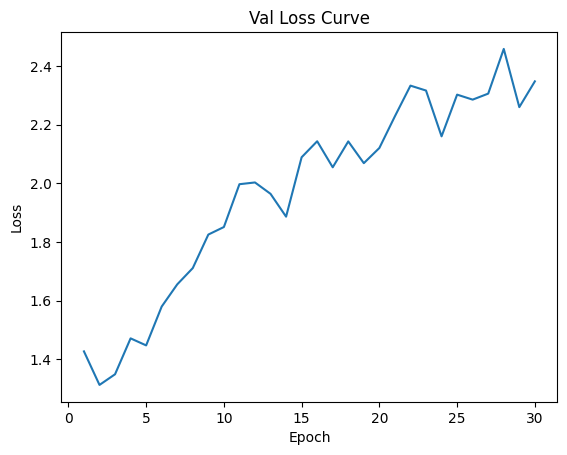

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [25]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # Replace the last fully connected layer with a new one
    teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, 30, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_rkd_wider_lambda{i}2.pth')
    torch.save(teacher_model, f'teacher_model_rkd_wider_lambda{i}2.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:03<00:00,  1.31it/s]


*******Epoch 0: loss - 1.5038484710234183


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:01<00:00,  1.33it/s]


*******Epoch 1: loss - 1.4533893782415508


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:01<00:00,  1.34it/s]


*******Epoch 2: loss - 1.3876485920246737


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:04<00:00,  1.30it/s]


Average Pretrain Adversary epoch loss:  0.3053731679180522


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:06<00:00,  1.28it/s]


Average Pretrain Adversary epoch loss:  0.3060722400744756


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:07<00:00,  1.27it/s]


Average Pretrain Adversary epoch loss:  0.30343214569636334


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.237122660525787


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 1/300*****
*****Train Loss:  4.633043 Val Loss:  4.136629*****
*****Validation Accuracy: 29.29%*****
*****Total Avg Disparity: 0.05499639412774108*****

Class Team_Sports: Recall Difference = 0.0821688599466377
Class Celebration: Recall Difference = -0.02380952380952378
Class Parade: Recall Difference = -0.07005587278197328
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = -0.031960335621662894
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.07198515769944341
Class Business: Recall Difference = -0.020833333333333332
Class Dresses: Recall Difference = 0.09471153846153829
Class Water Activities: Recall Difference = 0.004442925495557082
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = -0.095
Data has bee

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:53<00:00,  1.42it/s]


Average Adversary epoch loss: 0.2425066265794966


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 2/300*****
*****Train Loss:  4.469553 Val Loss:  4.125269*****
*****Validation Accuracy: 29.70%*****
*****Total Avg Disparity: 0.09112726625820498*****

Class Team_Sports: Recall Difference = 0.08445258445258458
Class Celebration: Recall Difference = 0.048771121351766505
Class Parade: Recall Difference = -0.05605697795788056
Class Waiter_Or_Waitress: Recall Difference = -0.02040816326530612
Class Individual_Sports: Recall Difference = -0.1502288329519451
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.08150896722325293
Class Business: Recall Difference = -0.07419217687074829
Class Dresses: Recall Difference = -0.22307692307692306
Class Water Activities: Recall Difference = 0.10344041922989289
Class Picnic: Recall Difference = -0.09090909090909091
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.08381527114240214
Class

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16911794130264976


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 3/300*****
*****Train Loss:  4.395457 Val Loss:  4.064323*****
*****Validation Accuracy: 31.75%*****
*****Total Avg Disparity: 0.10888385505930416*****

Class Team_Sports: Recall Difference = 0.1309410753855198
Class Celebration: Recall Difference = 0.03801843317972353
Class Parade: Recall Difference = -0.04181248848775093
Class Waiter_Or_Waitress: Recall Difference = -0.11930926216640501
Class Individual_Sports: Recall Difference = -0.16155606407322656
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.07643784786641933
Class Business: Recall Difference = -0.0669642857142857
Class Dresses: Recall Difference = -0.054807692307692224
Class Water Activities: Recall Difference = 0.21439963545226703
Class Picnic: Recall Difference = -0.32727272727272727
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.015086748805632391
Clas

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.41it/s]


Average Adversary epoch loss: 0.166634042551856


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 4/300*****
*****Train Loss:  4.335823 Val Loss:  4.021098*****
*****Validation Accuracy: 32.64%*****
*****Total Avg Disparity: 0.12432975446538955*****

Class Team_Sports: Recall Difference = 0.08359336137113915
Class Celebration: Recall Difference = -0.09485407066052232
Class Parade: Recall Difference = -0.15196168723521825
Class Waiter_Or_Waitress: Recall Difference = -0.15541601255886972
Class Individual_Sports: Recall Difference = -0.16403508771929828
Class Surgeons: Recall Difference = 0.02380952380952381
Class Spa: Recall Difference = -0.10204081632653061
Class Law_Enforcement: Recall Difference = 0.06505875077303652
Class Business: Recall Difference = -0.18005952380952384
Class Dresses: Recall Difference = -0.22307692307692312
Class Water Activities: Recall Difference = 0.1932102984734564
Class Picnic: Recall Difference = -0.23636363636363636
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Diffe

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.1659989542339319


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 5/300*****
*****Train Loss:  4.267688 Val Loss:  3.991675*****
*****Validation Accuracy: 33.56%*****
*****Total Avg Disparity: 0.11570244953215927*****

Class Team_Sports: Recall Difference = 0.06640889974223319
Class Celebration: Recall Difference = -0.08717357910906297
Class Parade: Recall Difference = -0.16467121016761843
Class Waiter_Or_Waitress: Recall Difference = -0.07613814756671901
Class Individual_Sports: Recall Difference = -0.14553775743707098
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.08163265306122448
Class Law_Enforcement: Recall Difference = 0.05615337043908472
Class Business: Recall Difference = -0.2115221088435374
Class Dresses: Recall Difference = -0.28125
Class Water Activities: Recall Difference = 0.08612440191387549
Class Picnic: Recall Difference = -0.18181818181818182
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.06403486715279523


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16764046808267818


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 6/300*****
*****Train Loss:  4.224440 Val Loss:  3.976267*****
*****Validation Accuracy: 33.30%*****
*****Total Avg Disparity: 0.14202548222431313*****

Class Team_Sports: Recall Difference = 0.13098629765296443
Class Celebration: Recall Difference = -0.09331797235023037
Class Parade: Recall Difference = -0.07005587278197334
Class Waiter_Or_Waitress: Recall Difference = -0.01020408163265306
Class Individual_Sports: Recall Difference = -0.11884057971014489
Class Surgeons: Recall Difference = 0.02380952380952381
Class Spa: Recall Difference = -0.22448979591836737
Class Law_Enforcement: Recall Difference = 0.1607915893630179
Class Business: Recall Difference = -0.0656887755102041
Class Dresses: Recall Difference = -0.41490384615384623
Class Water Activities: Recall Difference = 0.1098200045568467
Class Picnic: Recall Difference = -0.4
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.15044841

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16476788312012766


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 7/300*****
*****Train Loss:  4.193632 Val Loss:  3.869553*****
*****Validation Accuracy: 36.08%*****
*****Total Avg Disparity: 0.13781233792423447*****

Class Team_Sports: Recall Difference = 0.13299868855424402
Class Celebration: Recall Difference = 0.044546850998463894
Class Parade: Recall Difference = -0.08939645115736483
Class Waiter_Or_Waitress: Recall Difference = -0.07064364207221352
Class Individual_Sports: Recall Difference = -0.024180015255530152
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.6326530612244898
Class Law_Enforcement: Recall Difference = 0.07223252937538652
Class Business: Recall Difference = -0.04634353741496591
Class Dresses: Recall Difference = -0.27355769230769234
Class Water Activities: Recall Difference = 0.10309865573023469
Class Picnic: Recall Difference = -0.23636363636363636
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.03855619360131256
Class Performance_And_Entertainment: Recall Diffe

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16602412717025958


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 8/300*****
*****Train Loss:  4.151007 Val Loss:  3.832041*****
*****Validation Accuracy: 37.81%*****
*****Total Avg Disparity: 0.12754460583801477*****

Class Team_Sports: Recall Difference = 0.1466105910550357
Class Celebration: Recall Difference = 0.00883256528417814
Class Parade: Recall Difference = -0.13194572358322587
Class Waiter_Or_Waitress: Recall Difference = -0.08084772370486654
Class Individual_Sports: Recall Difference = -0.09290617848970262
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.4285714285714286
Class Law_Enforcement: Recall Difference = 0.09400123685837969
Class Business: Recall Difference = -0.11883503401360546
Class Dresses: Recall Difference = -0.21923076923076928
Class Water Activities: Recall Difference = 0.019480519480519487
Class Picnic: Recall Difference = -0.2545454545454545
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.003939317

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16624944404135517


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 9/300*****
*****Train Loss:  4.105319 Val Loss:  3.894537*****
*****Validation Accuracy: 35.38%*****
*****Total Avg Disparity: 0.13388434839691613*****

Class Team_Sports: Recall Difference = 0.04696332474110243
Class Celebration: Recall Difference = -0.036866359447004615
Class Parade: Recall Difference = -0.07306440719592316
Class Waiter_Or_Waitress: Recall Difference = -0.1271585557299843
Class Individual_Sports: Recall Difference = -0.10343249427917622
Class Surgeons: Recall Difference = 0.047619047619047616
Class Spa: Recall Difference = -0.4285714285714286
Class Law_Enforcement: Recall Difference = 0.20346320346320346
Class Business: Recall Difference = -0.19323979591836737
Class Dresses: Recall Difference = -0.21057692307692305
Class Water Activities: Recall Difference = -0.12292093871041235
Class Picnic: Recall Difference = -0.2727272727272727
Class Rescue: Recall Difference = 0.012987012987012988
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertain

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16596322773415365


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 10/300*****
*****Train Loss:  4.075521 Val Loss:  3.799475*****
*****Validation Accuracy: 38.12%*****
*****Total Avg Disparity: 0.11951527207276098*****

Class Team_Sports: Recall Difference = 0.10846560846560843
Class Celebration: Recall Difference = -0.037634408602150504
Class Parade: Recall Difference = -0.08724749800454346
Class Waiter_Or_Waitress: Recall Difference = -0.24411302982731553
Class Individual_Sports: Recall Difference = -0.0052631578947368585
Class Surgeons: Recall Difference = 0.01785714285714285
Class Spa: Recall Difference = -0.346938775510204
Class Law_Enforcement: Recall Difference = 0.03772418058132343
Class Business: Recall Difference = -0.04591836734693874
Class Dresses: Recall Difference = -0.43990384615384615
Class Water Activities: Recall Difference = -0.004101161995898717
Class Picnic: Recall Difference = -0.32727272727272727
Class Rescue: Recall Difference = 0.019730269730269732
Class Cheering: Recall Difference = 0.017432321575061527
Class Perf

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16358595396633502


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 11/300*****
*****Train Loss:  4.029015 Val Loss:  3.837933*****
*****Validation Accuracy: 38.96%*****
*****Total Avg Disparity: 0.0992413581309272*****

Class Team_Sports: Recall Difference = 0.0003843892732779963
Class Celebration: Recall Difference = -0.07795698924731183
Class Parade: Recall Difference = -0.13612083256585017
Class Waiter_Or_Waitress: Recall Difference = -0.109105180533752
Class Individual_Sports: Recall Difference = -0.17986270022883305
Class Surgeons: Recall Difference = -0.03869047619047619
Class Spa: Recall Difference = -0.08163265306122448
Class Law_Enforcement: Recall Difference = 0.21484230055658632
Class Business: Recall Difference = -0.12988945578231292
Class Dresses: Recall Difference = -0.24615384615384617
Class Water Activities: Recall Difference = 0.04044201412622461
Class Picnic: Recall Difference = -0.2909090909090909
Class Rescue: Recall Difference = -0.006243756243756244
Class Cheering: Recall Difference = 0.018867924528301886
Class Perform

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16492062043628575


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 12/300*****
*****Train Loss:  3.986099 Val Loss:  3.730325*****
*****Validation Accuracy: 39.08%*****
*****Total Avg Disparity: 0.13242244520017019*****

Class Team_Sports: Recall Difference = 0.11653778320444974
Class Celebration: Recall Difference = -0.03993855606758828
Class Parade: Recall Difference = -0.09547491864677349
Class Waiter_Or_Waitress: Recall Difference = -0.14756671899529042
Class Individual_Sports: Recall Difference = -0.1311594202898551
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.4897959183673469
Class Law_Enforcement: Recall Difference = 0.11910946196660493
Class Business: Recall Difference = -0.07823129251700678
Class Dresses: Recall Difference = -0.4043269230769231
Class Water Activities: Recall Difference = 0.026315789473684292
Class Picnic: Recall Difference = -0.23636363636363636
Class Rescue: Recall Difference = -0.019230769230769232
Class Cheering: Recall Difference = -0.0014356029532403575
Class Performance_And_Entert

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.1648926609368236


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 13/300*****
*****Train Loss:  3.955140 Val Loss:  3.671759*****
*****Validation Accuracy: 41.41%*****
*****Total Avg Disparity: 0.14607791039288087*****

Class Team_Sports: Recall Difference = 0.0971600416044861
Class Celebration: Recall Difference = -0.019201228878648224
Class Parade: Recall Difference = -0.0973168784920489
Class Waiter_Or_Waitress: Recall Difference = -0.17660910518053385
Class Individual_Sports: Recall Difference = -0.1012967200610222
Class Surgeons: Recall Difference = -0.17857142857142858
Class Spa: Recall Difference = -0.30612244897959184
Class Law_Enforcement: Recall Difference = 0.23735312306740874
Class Business: Recall Difference = -0.06866496598639454
Class Dresses: Recall Difference = -0.39807692307692305
Class Water Activities: Recall Difference = 0.018455228981544836
Class Picnic: Recall Difference = -0.38181818181818183
Class Rescue: Recall Difference = 0.03271728271728272
Class Cheering: Recall Difference = -0.0014356029532403627
Class Perfor

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16332134167537277


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 14/300*****
*****Train Loss:  3.912584 Val Loss:  3.693878*****
*****Validation Accuracy: 41.27%*****
*****Total Avg Disparity: 0.14673694360516512*****

Class Team_Sports: Recall Difference = 0.06489395378284268
Class Celebration: Recall Difference = -0.03917050691244242
Class Parade: Recall Difference = -0.19205501320071228
Class Waiter_Or_Waitress: Recall Difference = -0.18524332810047098
Class Individual_Sports: Recall Difference = -0.03752860411899317
Class Surgeons: Recall Difference = -0.03720238095238096
Class Spa: Recall Difference = -0.3673469387755102
Class Law_Enforcement: Recall Difference = 0.1694495980210266
Class Business: Recall Difference = 0.024022108843537393
Class Dresses: Recall Difference = -0.4855769230769231
Class Water Activities: Recall Difference = 0.07906128958760539
Class Picnic: Recall Difference = -0.4909090909090909
Class Rescue: Recall Difference = -0.01823176823176824
Class Cheering: Recall Difference = 0.006562756357670226
Class Performanc

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16423156908080902


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.75it/s]


*****Epoch 15/300*****
*****Train Loss:  3.894141 Val Loss:  3.704289*****
*****Validation Accuracy: 41.07%*****
*****Total Avg Disparity: 0.15134083923678845*****

Class Team_Sports: Recall Difference = 0.06756206756206729
Class Celebration: Recall Difference = -0.1025345622119816
Class Parade: Recall Difference = -0.08853686989623633
Class Waiter_Or_Waitress: Recall Difference = -0.1342229199372056
Class Individual_Sports: Recall Difference = -0.036422578184591936
Class Surgeons: Recall Difference = -0.16220238095238096
Class Spa: Recall Difference = -0.4693877551020408
Class Law_Enforcement: Recall Difference = 0.06666666666666676
Class Business: Recall Difference = -0.15093537414965993
Class Dresses: Recall Difference = -0.45
Class Water Activities: Recall Difference = 0.0035315561631351633
Class Picnic: Recall Difference = -0.4909090909090909
Class Rescue: Recall Difference = 0.012987012987012988
Class Cheering: Recall Difference = 0.015996718621821164
Class Performance_And_Entert

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16421842220940708


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 16/300*****
*****Train Loss:  3.868190 Val Loss:  3.673868*****
*****Validation Accuracy: 41.70%*****
*****Total Avg Disparity: 0.13489551396455823*****

Class Team_Sports: Recall Difference = 0.054786777008999255
Class Celebration: Recall Difference = -0.09408602150537637
Class Parade: Recall Difference = -0.16528519678271014
Class Waiter_Or_Waitress: Recall Difference = -0.15934065934065933
Class Individual_Sports: Recall Difference = -0.08588863463005342
Class Surgeons: Recall Difference = -0.07738095238095238
Class Spa: Recall Difference = -0.3877551020408163
Class Law_Enforcement: Recall Difference = 0.14434137291280147
Class Business: Recall Difference = 0.058248299319727886
Class Dresses: Recall Difference = -0.51875
Class Water Activities: Recall Difference = 0.018455228981544725
Class Picnic: Recall Difference = -0.18181818181818185
Class Rescue: Recall Difference = -0.019230769230769232
Class Cheering: Recall Difference = 0.04716981132075473
Class Performance_And_E

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.41it/s]


Average Adversary epoch loss: 0.16404421328578467


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 17/300*****
*****Train Loss:  3.826872 Val Loss:  3.737749*****
*****Validation Accuracy: 41.01%*****
*****Total Avg Disparity: 0.14418054425162313*****

Class Team_Sports: Recall Difference = 0.16191832858499522
Class Celebration: Recall Difference = -0.04800307219662059
Class Parade: Recall Difference = -0.15288266715785592
Class Waiter_Or_Waitress: Recall Difference = -0.2488226059654631
Class Individual_Sports: Recall Difference = -0.16632341723874922
Class Surgeons: Recall Difference = -0.07589285714285712
Class Spa: Recall Difference = -0.4285714285714286
Class Law_Enforcement: Recall Difference = 0.166852195423624
Class Business: Recall Difference = 0.026147959183673464
Class Dresses: Recall Difference = -0.34615384615384615
Class Water Activities: Recall Difference = 0.09466848940533151
Class Picnic: Recall Difference = -0.21818181818181817
Class Rescue: Recall Difference = 0.02022977022977023
Class Cheering: Recall Difference = 0.025430680885972116
Class Performance

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16456034324235386


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 18/300*****
*****Train Loss:  3.775973 Val Loss:  3.631950*****
*****Validation Accuracy: 42.16%*****
*****Total Avg Disparity: 0.15210701911192878*****

Class Team_Sports: Recall Difference = 0.0931804820693709
Class Celebration: Recall Difference = -0.0011520737327189168
Class Parade: Recall Difference = -0.07637993491741879
Class Waiter_Or_Waitress: Recall Difference = -0.2543171114599686
Class Individual_Sports: Recall Difference = -0.01922196796338682
Class Surgeons: Recall Difference = -0.1532738095238096
Class Spa: Recall Difference = -0.4693877551020408
Class Law_Enforcement: Recall Difference = 0.22152133580705013
Class Business: Recall Difference = 0.05590986394557823
Class Dresses: Recall Difference = -0.5043269230769232
Class Water Activities: Recall Difference = 0.010708589655958112
Class Picnic: Recall Difference = -0.23636363636363636
Class Rescue: Recall Difference = 0.013486513486513474
Class Cheering: Recall Difference = 0.007998359310910577
Class Performan

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.41it/s]


Average Adversary epoch loss: 0.16356728741048296


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 19/300*****
*****Train Loss:  3.735992 Val Loss:  3.624794*****
*****Validation Accuracy: 42.71%*****
*****Total Avg Disparity: 0.117435625301399*****

Class Team_Sports: Recall Difference = 0.11102066657622212
Class Celebration: Recall Difference = -0.03648233486943164
Class Parade: Recall Difference = -0.1571191748019894
Class Waiter_Or_Waitress: Recall Difference = -0.16718995290423863
Class Individual_Sports: Recall Difference = -0.07261632341723878
Class Surgeons: Recall Difference = -0.14732142857142858
Class Spa: Recall Difference = -0.20408163265306123
Class Law_Enforcement: Recall Difference = 0.1259121830550402
Class Business: Recall Difference = -0.005527210884353706
Class Dresses: Recall Difference = -0.4230769230769231
Class Water Activities: Recall Difference = -0.03394850763271812
Class Picnic: Recall Difference = -0.18181818181818185
Class Rescue: Recall Difference = -0.012487512487512488
Class Cheering: Recall Difference = 0.02399507793273175
Class Performan

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.1607521099532828


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 20/300*****
*****Train Loss:  3.698176 Val Loss:  3.625245*****
*****Validation Accuracy: 43.69%*****
*****Total Avg Disparity: 0.1821864375976311*****

Class Team_Sports: Recall Difference = 0.05116899561344013
Class Celebration: Recall Difference = -0.04262672811059909
Class Parade: Recall Difference = -0.12433228955608772
Class Waiter_Or_Waitress: Recall Difference = -0.29513343799058084
Class Individual_Sports: Recall Difference = -0.15331807780320372
Class Surgeons: Recall Difference = -0.25
Class Spa: Recall Difference = 0.7142857142857143
Class Law_Enforcement: Recall Difference = 0.1922077922077922
Class Business: Recall Difference = -0.07738095238095233
Class Dresses: Recall Difference = -0.5355769230769232
Class Water Activities: Recall Difference = 0.08623832308042845
Class Picnic: Recall Difference = -0.18181818181818185
Class Rescue: Recall Difference = -0.0052447552447552614
Class Cheering: Recall Difference = 0.034864643150123054
Class Performance_And_Entertai

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.1623038886413898


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 21/300*****
*****Train Loss:  3.664615 Val Loss:  3.657326*****
*****Validation Accuracy: 42.80%*****
*****Total Avg Disparity: 0.1425579172053535*****

Class Team_Sports: Recall Difference = 0.0575001130556686
Class Celebration: Recall Difference = 0.016513056835637474
Class Parade: Recall Difference = -0.17228464419475648
Class Waiter_Or_Waitress: Recall Difference = -0.1773940345368917
Class Individual_Sports: Recall Difference = -0.07585812356979393
Class Surgeons: Recall Difference = -0.19940476190476192
Class Spa: Recall Difference = -0.32653061224489793
Class Law_Enforcement: Recall Difference = 0.19443413729128012
Class Business: Recall Difference = 0.0038265306122449716
Class Dresses: Recall Difference = -0.50625
Class Water Activities: Recall Difference = -0.019252677147413966
Class Picnic: Recall Difference = -0.32727272727272727
Class Rescue: Recall Difference = -0.004745254745254723
Class Cheering: Recall Difference = 0.04286300246103363
Class Performance_And_En

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.41it/s]


Average Adversary epoch loss: 0.1599088137348493


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 22/300*****
*****Train Loss:  3.635300 Val Loss:  3.615906*****
*****Validation Accuracy: 44.04%*****
*****Total Avg Disparity: 0.15406020543421098*****

Class Team_Sports: Recall Difference = 0.07934246823135704
Class Celebration: Recall Difference = 0.03686635944700459
Class Parade: Recall Difference = -0.1294897771228587
Class Waiter_Or_Waitress: Recall Difference = -0.17189952904238615
Class Individual_Sports: Recall Difference = -0.15049580472921437
Class Surgeons: Recall Difference = -0.27083333333333337
Class Spa: Recall Difference = 0.44897959183673464
Class Law_Enforcement: Recall Difference = 0.09635126777983927
Class Business: Recall Difference = 0.024872448979591844
Class Dresses: Recall Difference = -0.47115384615384615
Class Water Activities: Recall Difference = 0.04158122579175222
Class Picnic: Recall Difference = -0.2727272727272728
Class Rescue: Recall Difference = -0.012487512487512488
Class Cheering: Recall Difference = 0.02399507793273175
Class Performanc

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.41it/s]


Average Adversary epoch loss: 0.15975775468496628


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 23/300*****
*****Train Loss:  3.585867 Val Loss:  3.604405*****
*****Validation Accuracy: 43.81%*****
*****Total Avg Disparity: 0.15644847747625817*****

Class Team_Sports: Recall Difference = 0.07807624474291142
Class Celebration: Recall Difference = -0.02112135176651303
Class Parade: Recall Difference = -0.10339534598145761
Class Waiter_Or_Waitress: Recall Difference = -0.1491365777080063
Class Individual_Sports: Recall Difference = -0.10213577421815412
Class Surgeons: Recall Difference = -0.24851190476190482
Class Spa: Recall Difference = -0.5102040816326531
Class Law_Enforcement: Recall Difference = 0.20568954854669141
Class Business: Recall Difference = 0.02380952380952378
Class Dresses: Recall Difference = -0.55
Class Water Activities: Recall Difference = 0.06356801093643194
Class Picnic: Recall Difference = -0.21818181818181817
Class Rescue: Recall Difference = -0.030219780219780223
Class Cheering: Recall Difference = 0.025430680885972116
Class Performance_And_Enterta

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16024841064656223


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 24/300*****
*****Train Loss:  3.551749 Val Loss:  3.598871*****
*****Validation Accuracy: 44.50%*****
*****Total Avg Disparity: 0.15862732457457215*****

Class Team_Sports: Recall Difference = 0.06349206349206349
Class Celebration: Recall Difference = -0.02649769585253453
Class Parade: Recall Difference = -0.12648124270890904
Class Waiter_Or_Waitress: Recall Difference = -0.1923076923076923
Class Individual_Sports: Recall Difference = -0.07826086956521738
Class Surgeons: Recall Difference = -0.16815476190476192
Class Spa: Recall Difference = -0.6122448979591837
Class Law_Enforcement: Recall Difference = 0.1306122448979592
Class Business: Recall Difference = -0.05994897959183676
Class Dresses: Recall Difference = -0.585576923076923
Class Water Activities: Recall Difference = 0.04180906812485763
Class Picnic: Recall Difference = -0.2909090909090909
Class Rescue: Recall Difference = 0.02647352647352648
Class Cheering: Recall Difference = 0.01025430680885972
Class Performance_An

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.15931986019383243


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 25/300*****
*****Train Loss:  3.515516 Val Loss:  3.676348*****
*****Validation Accuracy: 44.07%*****
*****Total Avg Disparity: 0.1267860249873076*****

Class Team_Sports: Recall Difference = 0.022339800117577857
Class Celebration: Recall Difference = -0.054531490015361006
Class Parade: Recall Difference = -0.19230060784674896
Class Waiter_Or_Waitress: Recall Difference = -0.2158555729984301
Class Individual_Sports: Recall Difference = -0.06414950419527077
Class Surgeons: Recall Difference = -0.03422619047619058
Class Spa: Recall Difference = -0.32653061224489793
Class Law_Enforcement: Recall Difference = 0.16277056277056268
Class Business: Recall Difference = -0.056335034013605456
Class Dresses: Recall Difference = -0.4875
Class Water Activities: Recall Difference = 0.070745044429255
Class Picnic: Recall Difference = -0.16363636363636366
Class Rescue: Recall Difference = 0.000999000999000993
Class Cheering: Recall Difference = 0.05229696472518457
Class Performance_And_Enter

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.36it/s]


Average Adversary epoch loss: 0.15905814484497646


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.67it/s]


*****Epoch 26/300*****
*****Train Loss:  3.488244 Val Loss:  3.578673*****
*****Validation Accuracy: 45.89%*****
*****Total Avg Disparity: 0.15301349761404776*****

Class Team_Sports: Recall Difference = 0.05872111427666993
Class Celebration: Recall Difference = 0.02419354838709678
Class Parade: Recall Difference = -0.15196168723521825
Class Waiter_Or_Waitress: Recall Difference = -0.23861852433281
Class Individual_Sports: Recall Difference = -0.004576659038901587
Class Surgeons: Recall Difference = -0.12053571428571425
Class Spa: Recall Difference = -0.22448979591836737
Class Law_Enforcement: Recall Difference = 0.23055040197897336
Class Business: Recall Difference = -0.05888605442176875
Class Dresses: Recall Difference = -0.6749999999999999
Class Water Activities: Recall Difference = 0.07860560492139435
Class Picnic: Recall Difference = -0.07272727272727272
Class Rescue: Recall Difference = 0.06593406593406595
Class Cheering: Recall Difference = 0.047990155865463485
Class Performance

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.15962478302327204


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 27/300*****
*****Train Loss:  3.444345 Val Loss:  3.591823*****
*****Validation Accuracy: 45.63%*****
*****Total Avg Disparity: 0.1420825656564918*****

Class Team_Sports: Recall Difference = 0.08768597657486554
Class Celebration: Recall Difference = -0.0011520737327189168
Class Parade: Recall Difference = -0.1552772149567141
Class Waiter_Or_Waitress: Recall Difference = -0.21585557299843014
Class Individual_Sports: Recall Difference = -0.09195270785659804
Class Surgeons: Recall Difference = -0.008928571428571452
Class Spa: Recall Difference = -0.4285714285714286
Class Law_Enforcement: Recall Difference = 0.17390228818800252
Class Business: Recall Difference = 0.004889455782312868
Class Dresses: Recall Difference = -0.5274038461538462
Class Water Activities: Recall Difference = 0.06322624743677374
Class Picnic: Recall Difference = -0.16363636363636372
Class Rescue: Recall Difference = 0.007242757242757247
Class Cheering: Recall Difference = 0.09372436423297785
Class Performa

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.37it/s]


Average Adversary epoch loss: 0.1587503336278009


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 28/300*****
*****Train Loss:  3.411169 Val Loss:  3.547043*****
*****Validation Accuracy: 45.28%*****
*****Total Avg Disparity: 0.1673703545806974*****

Class Team_Sports: Recall Difference = 0.05813322479989136
Class Celebration: Recall Difference = -0.031105990783410142
Class Parade: Recall Difference = -0.1224903297108123
Class Waiter_Or_Waitress: Recall Difference = -0.1899529042386186
Class Individual_Sports: Recall Difference = -0.06525553012967195
Class Surgeons: Recall Difference = -0.028273809523809507
Class Spa: Recall Difference = -0.5510204081632654
Class Law_Enforcement: Recall Difference = 0.1873840445269016
Class Business: Recall Difference = 0.055484693877551006
Class Dresses: Recall Difference = -0.71875
Class Water Activities: Recall Difference = 0.05627705627705637
Class Picnic: Recall Difference = -0.16363636363636366
Class Rescue: Recall Difference = 0.03996003996003997
Class Cheering: Recall Difference = 0.0551681706316653
Class Performance_And_Entertai

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.15766726976927417


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 29/300*****
*****Train Loss:  3.341455 Val Loss:  3.603209*****
*****Validation Accuracy: 46.35%*****
*****Total Avg Disparity: 0.1466059125743842*****

Class Team_Sports: Recall Difference = 0.10412427079093756
Class Celebration: Recall Difference = -0.10291858678955457
Class Parade: Recall Difference = -0.09455393872413587
Class Waiter_Or_Waitress: Recall Difference = -0.19780219780219785
Class Individual_Sports: Recall Difference = -0.061746758199847485
Class Surgeons: Recall Difference = -0.1220238095238095
Class Spa: Recall Difference = -0.26530612244897955
Class Law_Enforcement: Recall Difference = 0.20309214594928876
Class Business: Recall Difference = -0.03847789115646255
Class Dresses: Recall Difference = -0.625
Class Water Activities: Recall Difference = 0.0030758714969241208
Class Picnic: Recall Difference = -0.25454545454545463
Class Rescue: Recall Difference = -0.01148851148851146
Class Cheering: Recall Difference = 0.011689909762100069
Class Performance_And_Ent

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.37it/s]


Average Adversary epoch loss: 0.1569257670622549


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 30/300*****
*****Train Loss:  3.290680 Val Loss:  3.602642*****
*****Validation Accuracy: 46.61%*****
*****Total Avg Disparity: 0.15632593641088754*****

Class Team_Sports: Recall Difference = 0.04845565956677067
Class Celebration: Recall Difference = -0.005760368663594528
Class Parade: Recall Difference = -0.16682016332043959
Class Waiter_Or_Waitress: Recall Difference = -0.27943485086342235
Class Individual_Sports: Recall Difference = -0.020327993897788
Class Surgeons: Recall Difference = -0.21428571428571425
Class Spa: Recall Difference = -0.673469387755102
Class Law_Enforcement: Recall Difference = 0.11700680272108843
Class Business: Recall Difference = 0.002125850340136015
Class Dresses: Recall Difference = -0.49374999999999997
Class Water Activities: Recall Difference = 0.12360446570972883
Class Picnic: Recall Difference = -0.21818181818181817
Class Rescue: Recall Difference = 0.007742257742257744
Class Cheering: Recall Difference = 0.0951599671862182
Class Performance

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.15677129716416935


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 31/300*****
*****Train Loss:  3.272668 Val Loss:  3.651138*****
*****Validation Accuracy: 45.77%*****
*****Total Avg Disparity: 0.15195525500754778*****

Class Team_Sports: Recall Difference = 0.11637950526839425
Class Celebration: Recall Difference = 0.07526881720430101
Class Parade: Recall Difference = -0.07730091484005652
Class Waiter_Or_Waitress: Recall Difference = -0.3029827315541601
Class Individual_Sports: Recall Difference = -0.02383676582761257
Class Surgeons: Recall Difference = -0.049107142857142905
Class Spa: Recall Difference = -0.38775510204081637
Class Law_Enforcement: Recall Difference = 0.1986394557823129
Class Business: Recall Difference = 0.043367346938775586
Class Dresses: Recall Difference = -0.6249999999999999
Class Water Activities: Recall Difference = 0.10138983823194359
Class Picnic: Recall Difference = -0.16363636363636366
Class Rescue: Recall Difference = -0.012487512487512488
Class Cheering: Recall Difference = 0.08941755537325677
Class Performan

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.37it/s]


Average Adversary epoch loss: 0.15802600653267201


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.64it/s]


*****Epoch 32/300*****
*****Train Loss:  3.247511 Val Loss:  3.620938*****
*****Validation Accuracy: 46.35%*****
*****Total Avg Disparity: 0.15461124867474996*****

Class Team_Sports: Recall Difference = 0.08485958485958478
Class Celebration: Recall Difference = -0.07258064516129031
Class Parade: Recall Difference = -0.1488917541597593
Class Waiter_Or_Waitress: Recall Difference = -0.3304552590266877
Class Individual_Sports: Recall Difference = -0.09016018306636153
Class Surgeons: Recall Difference = -0.06547619047619047
Class Spa: Recall Difference = -0.4693877551020408
Class Law_Enforcement: Recall Difference = 0.17625231910946204
Class Business: Recall Difference = 0.03358843537414968
Class Dresses: Recall Difference = -0.51875
Class Water Activities: Recall Difference = 0.03383458646616555
Class Picnic: Recall Difference = -0.21818181818181823
Class Rescue: Recall Difference = -0.011488511488511474
Class Cheering: Recall Difference = 0.0734208367514356
Class Performance_And_Enterta

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.37it/s]


Average Adversary epoch loss: 0.16059595139490235


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.64it/s]


*****Epoch 33/300*****
*****Train Loss:  3.199702 Val Loss:  3.656228*****
*****Validation Accuracy: 44.50%*****
*****Total Avg Disparity: 0.1402718998480506*****

Class Team_Sports: Recall Difference = 0.07879980102202322
Class Celebration: Recall Difference = -0.02649769585253453
Class Parade: Recall Difference = -0.12163074844968386
Class Waiter_Or_Waitress: Recall Difference = -0.22841444270015707
Class Individual_Sports: Recall Difference = -0.01826849733028224
Class Surgeons: Recall Difference = -0.09672619047619052
Class Spa: Recall Difference = -0.44897959183673464
Class Law_Enforcement: Recall Difference = 0.15794681508967223
Class Business: Recall Difference = 0.014455782312925214
Class Dresses: Recall Difference = -0.625
Class Water Activities: Recall Difference = 0.06368193210298478
Class Picnic: Recall Difference = -0.18181818181818185
Class Rescue: Recall Difference = -0.029220779220779175
Class Cheering: Recall Difference = 0.009639048400328115
Class Performance_And_Ente

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.36it/s]


Average Adversary epoch loss: 0.15840681568707948


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 34/300*****
*****Train Loss:  3.137077 Val Loss:  3.748436*****
*****Validation Accuracy: 45.45%*****
*****Total Avg Disparity: 0.14455896889830566*****

Class Team_Sports: Recall Difference = 0.07043368154479268
Class Celebration: Recall Difference = -0.041090629800307255
Class Parade: Recall Difference = -0.019954564990483203
Class Waiter_Or_Waitress: Recall Difference = -0.14835164835164827
Class Individual_Sports: Recall Difference = -0.08142639206712443
Class Surgeons: Recall Difference = -0.17559523809523808
Class Spa: Recall Difference = -0.4081632653061224
Class Law_Enforcement: Recall Difference = 0.18515769944341376
Class Business: Recall Difference = 0.04400510204081631
Class Dresses: Recall Difference = -0.7125000000000001
Class Water Activities: Recall Difference = 0.0710868079289132
Class Picnic: Recall Difference = -0.1272727272727273
Class Rescue: Recall Difference = 0.026473526473526465
Class Cheering: Recall Difference = 0.02481542247744052
Class Performanc

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:58<00:00,  1.37it/s]


Average Adversary epoch loss: 0.15898283575603991


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.74it/s]


*****Epoch 35/300*****
*****Train Loss:  3.099009 Val Loss:  3.666727*****
*****Validation Accuracy: 46.96%*****
*****Total Avg Disparity: 0.1404899936153471*****

Class Team_Sports: Recall Difference = 0.04633021299687978
Class Celebration: Recall Difference = 0.00883256528417814
Class Parade: Recall Difference = -0.08515994351323136
Class Waiter_Or_Waitress: Recall Difference = -0.19701726844583983
Class Individual_Sports: Recall Difference = -0.04420289855072462
Class Surgeons: Recall Difference = -0.035714285714285726
Class Spa: Recall Difference = -0.4693877551020408
Class Law_Enforcement: Recall Difference = 0.1646258503401361
Class Business: Recall Difference = 0.002763605442176853
Class Dresses: Recall Difference = -0.66875
Class Water Activities: Recall Difference = 0.04864433811802238
Class Picnic: Recall Difference = -0.20000000000000004
Class Rescue: Recall Difference = -0.005744255744255737
Class Cheering: Recall Difference = -0.0034864643150123026
Class Performance_And_En

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.1598347660476043


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 36/300*****
*****Train Loss:  3.059891 Val Loss:  3.730755*****
*****Validation Accuracy: 46.12%*****
*****Total Avg Disparity: 0.14882974942928787*****

Class Team_Sports: Recall Difference = 0.10195360195360192
Class Celebration: Recall Difference = 0.041090629800307144
Class Parade: Recall Difference = -0.05544299134278874
Class Waiter_Or_Waitress: Recall Difference = -0.31240188383045525
Class Individual_Sports: Recall Difference = -0.023493516399694825
Class Surgeons: Recall Difference = -0.07291666666666674
Class Spa: Recall Difference = -0.3469387755102041
Class Law_Enforcement: Recall Difference = 0.16907854050711196
Class Business: Recall Difference = 0.12521258503401356
Class Dresses: Recall Difference = -0.6187500000000001
Class Water Activities: Recall Difference = 0.05627705627705637
Class Picnic: Recall Difference = -0.23636363636363636
Class Rescue: Recall Difference = -0.06293706293706294
Class Cheering: Recall Difference = 0.05311730926989336
Class Performan

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.40it/s]


Average Adversary epoch loss: 0.1587201597881906


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 37/300*****
*****Train Loss:  3.007311 Val Loss:  3.724073*****
*****Validation Accuracy: 46.93%*****
*****Total Avg Disparity: 0.13021925355727393*****

Class Team_Sports: Recall Difference = 0.03880070546737224
Class Celebration: Recall Difference = -0.03993855606758834
Class Parade: Recall Difference = -0.09277337754036963
Class Waiter_Or_Waitress: Recall Difference = -0.1899529042386186
Class Individual_Sports: Recall Difference = -0.11548436308161714
Class Surgeons: Recall Difference = -0.019345238095238027
Class Spa: Recall Difference = -0.4285714285714286
Class Law_Enforcement: Recall Difference = 0.10562770562770557
Class Business: Recall Difference = -0.0170068027210884
Class Dresses: Recall Difference = -0.541826923076923
Class Water Activities: Recall Difference = 0.01856915014809779
Class Picnic: Recall Difference = -0.09090909090909091
Class Rescue: Recall Difference = 0.03421578421578425
Class Cheering: Recall Difference = 0.051066447908121426
Class Performance

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.15991248034032773


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 38/300*****
*****Train Loss:  2.963834 Val Loss:  3.842254*****
*****Validation Accuracy: 46.26%*****
*****Total Avg Disparity: 0.16374090079518752*****

Class Team_Sports: Recall Difference = 0.07115723782390448
Class Celebration: Recall Difference = -0.04646697388632881
Class Parade: Recall Difference = -0.1744335973475778
Class Waiter_Or_Waitress: Recall Difference = -0.08241758241758246
Class Individual_Sports: Recall Difference = -0.037871853546910805
Class Surgeons: Recall Difference = -0.07142857142857145
Class Spa: Recall Difference = -0.44897959183673464
Class Law_Enforcement: Recall Difference = 0.2755720470006184
Class Business: Recall Difference = -0.03677721088435365
Class Dresses: Recall Difference = -0.6687500000000001
Class Water Activities: Recall Difference = 0.011619958988380086
Class Picnic: Recall Difference = -0.4181818181818182
Class Rescue: Recall Difference = 0.0591908091908092
Class Cheering: Recall Difference = 0.08141919606234621
Class Performance

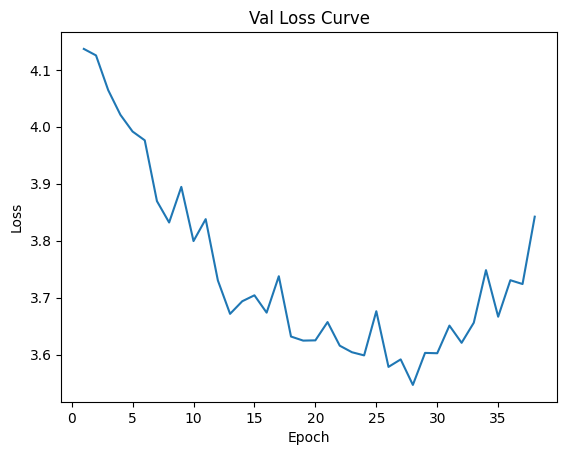

Student weights and architecture saved and exported for lambda: 0


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:05<00:00,  1.29it/s]


*******Epoch 0: loss - 1.5012922949261136


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:02<00:00,  1.32it/s]


*******Epoch 1: loss - 1.431603467758791


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:03<00:00,  1.31it/s]


*******Epoch 2: loss - 1.392252680696087


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:08<00:00,  1.26it/s]


Average Pretrain Adversary epoch loss:  0.3415001411864787


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:08<00:00,  1.26it/s]


Average Pretrain Adversary epoch loss:  0.34547763722546304


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:08<00:00,  1.26it/s]


Average Pretrain Adversary epoch loss:  0.3434757616048978


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.22239439203231423


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 1/300*****
*****Train Loss:  17.852716 Val Loss:  26.645349*****
*****Validation Accuracy: 20.75%*****
*****Total Avg Disparity: 0.029996341267100473*****

Class Team_Sports: Recall Difference = -0.04282548726993174
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = -0.022103518143304524
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.04077040427154838
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water Activities: Recall Difference = -0.01594896331738438
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.02833333333333335
Data has been appended to ./runs_2023_12_04_17_32/validation_3

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.1852411698595977


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.69it/s]


*****Epoch 2/300*****
*****Train Loss:  29.696146 Val Loss:  36.921622*****
*****Validation Accuracy: 23.78%*****
*****Total Avg Disparity: 0.01783953413332656*****

Class Team_Sports: Recall Difference = -0.002871613982725063
Class Celebration: Recall Difference = -0.011136712749615975
Class Parade: Recall Difference = 0.00036839196905508187
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = -0.04549961861174684
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.009029066171923315
Class Business: Recall Difference = 0.01020408163265306
Class Dresses: Recall Difference = 0.05096153846153845
Class Water Activities: Recall Difference = -0.012645249487354682
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16652380596892333


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.75it/s]


*****Epoch 3/300*****
*****Train Loss:  28.547275 Val Loss:  30.547475*****
*****Validation Accuracy: 25.54%*****
*****Total Avg Disparity: 0.06417970598467804*****

Class Team_Sports: Recall Difference = 0.042780265002487106
Class Celebration: Recall Difference = -0.01497695852534562
Class Parade: Recall Difference = -0.09314176950942474
Class Waiter_Or_Waitress: Recall Difference = -0.08163265306122448
Class Individual_Sports: Recall Difference = -0.14263920671243324
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.08831168831168831
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.024999999999999998
Class Water Activities: Recall Difference = 0.1263385737069948
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.010309278350515464
Class Family: Recall Difference = 

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.1685293274069274


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 4/300*****
*****Train Loss:  30.515696 Val Loss:  35.442800*****
*****Validation Accuracy: 29.90%*****
*****Total Avg Disparity: 0.08062847738631197*****

Class Team_Sports: Recall Difference = 0.005155338488671779
Class Celebration: Recall Difference = -0.12250384024577568
Class Parade: Recall Difference = -0.08761588997359859
Class Waiter_Or_Waitress: Recall Difference = -0.05102040816326531
Class Individual_Sports: Recall Difference = -0.16315789473684217
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.05442176870748299
Class Business: Recall Difference = -0.09587585034013604
Class Dresses: Recall Difference = 0.0
Class Water Activities: Recall Difference = 0.06527682843472316
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.41it/s]


Average Adversary epoch loss: 0.16663589213549354


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 5/300*****
*****Train Loss:  28.640775 Val Loss:  33.167584*****
*****Validation Accuracy: 30.48%*****
*****Total Avg Disparity: 0.046618529732732936*****

Class Team_Sports: Recall Difference = 0.11583683805906031
Class Celebration: Recall Difference = -0.07565284178187404
Class Parade: Recall Difference = -0.05667096457297233
Class Waiter_Or_Waitress: Recall Difference = 0.010989010989011033
Class Individual_Sports: Recall Difference = -0.10488176964149515
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.02040816326530612
Class Law_Enforcement: Recall Difference = 0.029313543599257877
Class Business: Recall Difference = -0.024447278911564646
Class Dresses: Recall Difference = -0.07740384615384613
Class Water Activities: Recall Difference = 0.03394850763271817
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.010869565217391304
Class Performance_And_Entertainment: Recall Difference = 0

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16483940763605964


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 6/300*****
*****Train Loss:  30.131151 Val Loss:  33.186617*****
*****Validation Accuracy: 32.99%*****
*****Total Avg Disparity: 0.0877317878026861*****

Class Team_Sports: Recall Difference = 0.1493917605028714
Class Celebration: Recall Difference = -0.04953917050691242
Class Parade: Recall Difference = -0.11739424080555044
Class Waiter_Or_Waitress: Recall Difference = -0.05102040816326531
Class Individual_Sports: Recall Difference = -0.17822273073989325
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.02040816326530612
Class Law_Enforcement: Recall Difference = 0.25590599876314163
Class Business: Recall Difference = -0.08460884353741495
Class Dresses: Recall Difference = -0.037980769230769235
Class Water Activities: Recall Difference = 0.018910913647755767
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Reca

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16642955515855623


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.71it/s]


*****Epoch 7/300*****
*****Train Loss:  28.213606 Val Loss:  30.892367*****
*****Validation Accuracy: 32.84%*****
*****Total Avg Disparity: 0.08676813527794282*****

Class Team_Sports: Recall Difference = 0.11237733459955679
Class Celebration: Recall Difference = -0.04301075268817206
Class Parade: Recall Difference = -0.12433228955608772
Class Waiter_Or_Waitress: Recall Difference = -0.027472527472527472
Class Individual_Sports: Recall Difference = -0.10839054157131961
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.1020408163265306
Class Law_Enforcement: Recall Difference = 0.08818800247371673
Class Business: Recall Difference = -0.07525510204081633
Class Dresses: Recall Difference = -0.3024038461538462
Class Water Activities: Recall Difference = 0.050353155616313594
Class Picnic: Recall Difference = -0.03636363636363636
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.022

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16605970824574245


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 8/300*****
*****Train Loss:  28.734140 Val Loss:  31.835033*****
*****Validation Accuracy: 34.57%*****
*****Total Avg Disparity: 0.11398760062125902*****

Class Team_Sports: Recall Difference = 0.1179622846289512
Class Celebration: Recall Difference = 0.050691244239631325
Class Parade: Recall Difference = -0.11671885552894956
Class Waiter_Or_Waitress: Recall Difference = -0.05337519623233909
Class Individual_Sports: Recall Difference = -0.22589626239511817
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.1836734693877551
Class Law_Enforcement: Recall Difference = 0.17835497835497838
Class Business: Recall Difference = -0.0665391156462585
Class Dresses: Recall Difference = -0.13365384615384612
Class Water Activities: Recall Difference = 0.07165641376167703
Class Picnic: Recall Difference = -0.2545454545454545
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.003771

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16717765360702702


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 9/300*****
*****Train Loss:  28.560358 Val Loss:  33.570716*****
*****Validation Accuracy: 35.56%*****
*****Total Avg Disparity: 0.10296506893089732*****

Class Team_Sports: Recall Difference = 0.0883190883190883
Class Celebration: Recall Difference = -0.05645161290322584
Class Parade: Recall Difference = -0.10916682016332047
Class Waiter_Or_Waitress: Recall Difference = -0.152276295133438
Class Individual_Sports: Recall Difference = -0.18943554538520224
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.14285714285714285
Class Law_Enforcement: Recall Difference = 0.14446505875077303
Class Business: Recall Difference = -0.10034013605442182
Class Dresses: Recall Difference = -0.1836538461538461
Class Water Activities: Recall Difference = 0.11836409204830267
Class Picnic: Recall Difference = -0.09090909090909091
Class Rescue: Recall Difference = 0.012987012987012988
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Diffe

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.1630151592378999


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.76it/s]


*****Epoch 10/300*****
*****Train Loss:  29.450232 Val Loss:  32.710365*****
*****Validation Accuracy: 35.12%*****
*****Total Avg Disparity: 0.12522311795539237*****

Class Team_Sports: Recall Difference = 0.16316194093971859
Class Celebration: Recall Difference = -0.08256528417818745
Class Parade: Recall Difference = -0.016946030576533433
Class Waiter_Or_Waitress: Recall Difference = -0.08398744113029827
Class Individual_Sports: Recall Difference = -0.19183829138062553
Class Surgeons: Recall Difference = -0.007440476190476192
Class Spa: Recall Difference = -0.3469387755102041
Class Law_Enforcement: Recall Difference = 0.16227581941867658
Class Business: Recall Difference = 0.016369047619047616
Class Dresses: Recall Difference = -0.31057692307692303
Class Water Activities: Recall Difference = 0.09455456823877884
Class Picnic: Recall Difference = -0.21818181818181817
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:55<00:00,  1.40it/s]


Average Adversary epoch loss: 0.16420075899840872


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.68it/s]


*****Epoch 11/300*****
*****Train Loss:  28.699448 Val Loss:  33.003636*****
*****Validation Accuracy: 35.09%*****
*****Total Avg Disparity: 0.08010264543362478*****

Class Team_Sports: Recall Difference = 0.08684936462714243
Class Celebration: Recall Difference = 0.027649769585253475
Class Parade: Recall Difference = 0.006446859458463822
Class Waiter_Or_Waitress: Recall Difference = -0.1248037676609105
Class Individual_Sports: Recall Difference = -0.1765064836003052
Class Surgeons: Recall Difference = -0.007440476190476192
Class Spa: Recall Difference = -0.08163265306122448
Class Law_Enforcement: Recall Difference = 0.15596784168212738
Class Business: Recall Difference = -0.09800170068027214
Class Dresses: Recall Difference = -0.20865384615384608
Class Water Activities: Recall Difference = -0.010594668489405379
Class Picnic: Recall Difference = -0.23636363636363636
Class Rescue: Recall Difference = 0.012987012987012988
Class Cheering: Recall Difference = 0.009433962264150943
Class Per

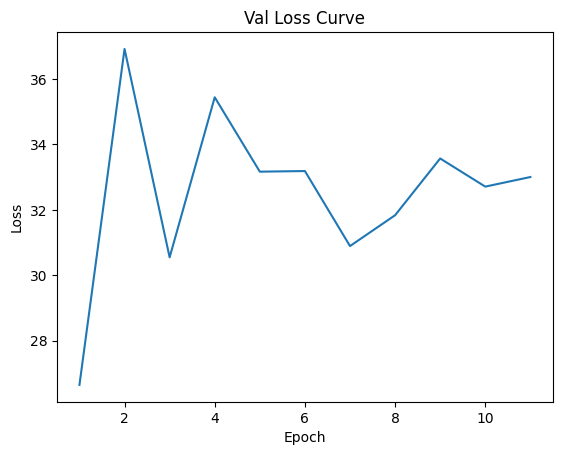

Student weights and architecture saved and exported for lambda: 3


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:02<00:00,  1.32it/s]


*******Epoch 0: loss - 1.5023696371066717


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:03<00:00,  1.31it/s]


*******Epoch 1: loss - 1.436304905532319


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:01<00:00,  1.33it/s]


*******Epoch 2: loss - 1.398368524916378


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:06<00:00,  1.28it/s]


Average Pretrain Adversary epoch loss:  0.44768579708941186


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:05<00:00,  1.29it/s]


Average Pretrain Adversary epoch loss:  0.4487446493204729


100%|████████████████████████████████████████████████████████████████████████| 162/162 [02:07<00:00,  1.27it/s]


Average Pretrain Adversary epoch loss:  0.45016782813602024


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.40it/s]


Average Adversary epoch loss: 0.24757993442040901


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 1/300*****
*****Train Loss:  26.991451 Val Loss:  30.595105*****
*****Validation Accuracy: 21.07%*****
*****Total Avg Disparity: 0.035459924709613865*****

Class Team_Sports: Recall Difference = 0.025505358838692205
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = 0.02069134892859331
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.06018306636155607
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = 0.0
Class Water Activities: Recall Difference = 0.0
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.0
Data has been appended to ./runs_2023_12_04_17_32/validation_5.txt


100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.1734463429009473


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.70it/s]


*****Epoch 2/300*****
*****Train Loss:  30.284819 Val Loss:  34.653127*****
*****Validation Accuracy: 24.18%*****
*****Total Avg Disparity: 0.055967456765841674*****

Class Team_Sports: Recall Difference = 0.0843395287839731
Class Celebration: Recall Difference = 0.09178187403993854
Class Parade: Recall Difference = -0.044575428255664046
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = -0.0062166285278413835
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.024999999999999998
Class Water Activities: Recall Difference = 0.07985873775347463
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0
Class Family: Recall Difference = 0.06
Data has been appended to ./runs_2023_12_04

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:56<00:00,  1.39it/s]


Average Adversary epoch loss: 0.16819471010455378


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 3/300*****
*****Train Loss:  30.013481 Val Loss:  32.590221*****
*****Validation Accuracy: 25.80%*****
*****Total Avg Disparity: 0.04703649247234276*****

Class Team_Sports: Recall Difference = 0.10624971736082844
Class Celebration: Recall Difference = -0.05990783410138248
Class Parade: Recall Difference = 0.020445754282556627
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = -0.002440884820747502
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = -0.004576376004947433
Class Business: Recall Difference = -0.021471088435374146
Class Dresses: Recall Difference = -0.17548076923076925
Class Water Activities: Recall Difference = -0.032581453634085156
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.022211046852736567
Class Family: Recall Differe

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:57<00:00,  1.38it/s]


Average Adversary epoch loss: 0.16655532758177063


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.72it/s]


*****Epoch 4/300*****
*****Train Loss:  29.400907 Val Loss:  32.578247*****
*****Validation Accuracy: 26.29%*****
*****Total Avg Disparity: 0.04424664222300563*****

Class Team_Sports: Recall Difference = 0.07054673721340399
Class Celebration: Recall Difference = -0.04147465437788017
Class Parade: Recall Difference = -0.007859028673174923
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = -0.02562929061784902
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = -0.00470006184291899
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.15432692307692306
Class Water Activities: Recall Difference = -0.056732740943267246
Class Picnic: Recall Difference = -0.03636363636363637
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.0005867068979968221
Class Family: Recall Differenc

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.41it/s]


Average Adversary epoch loss: 0.16884176345703042


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.73it/s]


*****Epoch 5/300*****
*****Train Loss:  28.328055 Val Loss:  33.452079*****
*****Validation Accuracy: 26.00%*****
*****Total Avg Disparity: 0.059890538303567616*****

Class Team_Sports: Recall Difference = 0.06462262017817572
Class Celebration: Recall Difference = -0.05184331797235024
Class Parade: Recall Difference = -0.05845152575673851
Class Waiter_Or_Waitress: Recall Difference = -0.09890109890109895
Class Individual_Sports: Recall Difference = -0.12227307398932113
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = -0.034632034632034625
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.024999999999999998
Class Water Activities: Recall Difference = 0.04647983595352001
Class Picnic: Recall Difference = -0.07272727272727272
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.005531807895398533
Class Family: 

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:54<00:00,  1.42it/s]


Average Adversary epoch loss: 0.165347033628711


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.82it/s]


*****Epoch 6/300*****
*****Train Loss:  30.359968 Val Loss:  33.621336*****
*****Validation Accuracy: 30.82%*****
*****Total Avg Disparity: 0.07791116131283049*****

Class Team_Sports: Recall Difference = 0.08560575227241896
Class Celebration: Recall Difference = 0.040322580645161255
Class Parade: Recall Difference = -0.08884386320378218
Class Waiter_Or_Waitress: Recall Difference = -0.15777080062794346
Class Individual_Sports: Recall Difference = -0.00022883295194509046
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.02040816326530612
Class Law_Enforcement: Recall Difference = 0.058503401360544216
Class Business: Recall Difference = 0.0
Class Dresses: Recall Difference = -0.21057692307692305
Class Water Activities: Recall Difference = 0.1553884711779449
Class Picnic: Recall Difference = -0.07272727272727272
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.02455787444472385

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.16401511393947366


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:20<00:00,  2.66it/s]


*****Epoch 7/300*****
*****Train Loss:  29.538811 Val Loss:  32.389686*****
*****Validation Accuracy: 32.93%*****
*****Total Avg Disparity: 0.16345519315946516*****

Class Team_Sports: Recall Difference = 0.09987337765115545
Class Celebration: Recall Difference = -0.006528417818740417
Class Parade: Recall Difference = -0.05212746362129306
Class Waiter_Or_Waitress: Recall Difference = -0.1295133437990581
Class Individual_Sports: Recall Difference = -0.09565217391304354
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.9591836734693877
Class Law_Enforcement: Recall Difference = 0.16054421768707478
Class Business: Recall Difference = -0.031249999999999997
Class Dresses: Recall Difference = -0.21490384615384617
Class Water Activities: Recall Difference = 0.11745272271588064
Class Picnic: Recall Difference = -0.20000000000000004
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.009

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.43it/s]


Average Adversary epoch loss: 0.16560325748574586


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 8/300*****
*****Train Loss:  29.118743 Val Loss:  30.873881*****
*****Validation Accuracy: 33.39%*****
*****Total Avg Disparity: 0.13509601346010258*****

Class Team_Sports: Recall Difference = 0.09039931262153489
Class Celebration: Recall Difference = -0.07565284178187404
Class Parade: Recall Difference = -0.06336341867747286
Class Waiter_Or_Waitress: Recall Difference = -0.10125588697017271
Class Individual_Sports: Recall Difference = -0.12406559877955764
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.061224489795918366
Class Law_Enforcement: Recall Difference = 0.28954854669140384
Class Business: Recall Difference = -0.05293367346938775
Class Dresses: Recall Difference = -0.39375
Class Water Activities: Recall Difference = 0.09387104123946233
Class Picnic: Recall Difference = -0.3818181818181819
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.02003184980303

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.45it/s]


Average Adversary epoch loss: 0.16490533685794584


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 9/300*****
*****Train Loss:  27.647917 Val Loss:  30.717085*****
*****Validation Accuracy: 34.75%*****
*****Total Avg Disparity: 0.1479764429515907*****

Class Team_Sports: Recall Difference = 0.044408266630489024
Class Celebration: Recall Difference = 0.052995391705069124
Class Parade: Recall Difference = -0.03997052864247552
Class Waiter_Or_Waitress: Recall Difference = -0.10125588697017268
Class Individual_Sports: Recall Difference = -0.12131960335621667
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.9387755102040817
Class Law_Enforcement: Recall Difference = 0.20766852195423618
Class Business: Recall Difference = 0.03613945578231295
Class Dresses: Recall Difference = -0.1399038461538461
Class Water Activities: Recall Difference = -0.0042150831624515606
Class Picnic: Recall Difference = -0.07272727272727272
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = -0.112

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.16385221536512729


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 10/300*****
*****Train Loss:  28.163476 Val Loss:  29.740214*****
*****Validation Accuracy: 36.31%*****
*****Total Avg Disparity: 0.18848746200218758*****

Class Team_Sports: Recall Difference = 0.0855831411386968
Class Celebration: Recall Difference = -0.02956989247311831
Class Parade: Recall Difference = -0.08061644256155204
Class Waiter_Or_Waitress: Recall Difference = -0.12166405023547877
Class Individual_Sports: Recall Difference = -0.0715102974828376
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.9387755102040817
Class Law_Enforcement: Recall Difference = 0.2238713667285096
Class Business: Recall Difference = -0.07674319727891157
Class Dresses: Recall Difference = -0.3
Class Water Activities: Recall Difference = 0.16210982000455693
Class Picnic: Recall Difference = -0.2545454545454545
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.017014500041907632
Class

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:51<00:00,  1.45it/s]


Average Adversary epoch loss: 0.16277878864863773


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 11/300*****
*****Train Loss:  29.231678 Val Loss:  33.167094*****
*****Validation Accuracy: 35.53%*****
*****Total Avg Disparity: 0.1581751104495586*****

Class Team_Sports: Recall Difference = 0.05128205128205121
Class Celebration: Recall Difference = -0.06182795698924734
Class Parade: Recall Difference = -0.08908945784981892
Class Waiter_Or_Waitress: Recall Difference = -0.029827315541601257
Class Individual_Sports: Recall Difference = -0.11498855835240279
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.8979591836734694
Class Law_Enforcement: Recall Difference = 0.18750773036487323
Class Business: Recall Difference = -0.014030612244897961
Class Dresses: Recall Difference = -0.26875
Class Water Activities: Recall Difference = 0.0872636135794031
Class Picnic: Recall Difference = -0.2909090909090909
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.009433962264150943
Class Performance_And_Entertainment: Recall Difference = -0

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:51<00:00,  1.45it/s]


Average Adversary epoch loss: 0.16181301394546474


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 12/300*****
*****Train Loss:  28.491674 Val Loss:  30.768899*****
*****Validation Accuracy: 37.43%*****
*****Total Avg Disparity: 0.15183122768443433*****

Class Team_Sports: Recall Difference = 0.0724912947135169
Class Celebration: Recall Difference = -0.10752688172043012
Class Parade: Recall Difference = -0.07269601522686797
Class Waiter_Or_Waitress: Recall Difference = -0.1546310832025118
Class Individual_Sports: Recall Difference = -0.17284515636918385
Class Surgeons: Recall Difference = -0.03125
Class Spa: Recall Difference = 0.7142857142857143
Class Law_Enforcement: Recall Difference = 0.048732220160791595
Class Business: Recall Difference = -0.05612244897959179
Class Dresses: Recall Difference = -0.5125
Class Water Activities: Recall Difference = 0.018455228981544725
Class Picnic: Recall Difference = -0.2545454545454546
Class Rescue: Recall Difference = -0.01923076923076923
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference 

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:51<00:00,  1.45it/s]


Average Adversary epoch loss: 0.1619773212314388


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 13/300*****
*****Train Loss:  28.589511 Val Loss:  32.219272*****
*****Validation Accuracy: 38.59%*****
*****Total Avg Disparity: 0.11401638400533495*****

Class Team_Sports: Recall Difference = 0.16250621806177368
Class Celebration: Recall Difference = -0.028801843317972364
Class Parade: Recall Difference = -0.0824584024068275
Class Waiter_Or_Waitress: Recall Difference = -0.12166405023547883
Class Individual_Sports: Recall Difference = -0.19080854309687273
Class Surgeons: Recall Difference = -0.03125
Class Spa: Recall Difference = -0.12244897959183673
Class Law_Enforcement: Recall Difference = 0.16004947433518874
Class Business: Recall Difference = -0.023596938775510168
Class Dresses: Recall Difference = -0.32307692307692304
Class Water Activities: Recall Difference = 0.08646616541353391
Class Picnic: Recall Difference = -0.290909090909091
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.013740771123872036
Class Performance_And_Entertainment: Re

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.16191032860014173


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.80it/s]


*****Epoch 14/300*****
*****Train Loss:  28.186751 Val Loss:  33.121405*****
*****Validation Accuracy: 38.56%*****
*****Total Avg Disparity: 0.132621460981086*****

Class Team_Sports: Recall Difference = 0.03672048116492577
Class Celebration: Recall Difference = 0.009216589861751168
Class Parade: Recall Difference = -0.050899490391109525
Class Waiter_Or_Waitress: Recall Difference = -0.2135007849293564
Class Individual_Sports: Recall Difference = -0.10350877192982472
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = -0.22448979591836737
Class Law_Enforcement: Recall Difference = 0.21929499072356207
Class Business: Recall Difference = 0.07546768707482998
Class Dresses: Recall Difference = -0.24182692307692305
Class Water Activities: Recall Difference = 0.04112554112554123
Class Picnic: Recall Difference = -0.4727272727272727
Class Rescue: Recall Difference = -0.044705294705294704
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Dif

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:51<00:00,  1.45it/s]


Average Adversary epoch loss: 0.16214710101485252


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.79it/s]


*****Epoch 15/300*****
*****Train Loss:  28.265973 Val Loss:  32.169068*****
*****Validation Accuracy: 40.00%*****
*****Total Avg Disparity: 0.12716472993256916*****

Class Team_Sports: Recall Difference = 0.10204404648849086
Class Celebration: Recall Difference = -0.014592933947772613
Class Parade: Recall Difference = -0.03874255541229199
Class Waiter_Or_Waitress: Recall Difference = -0.13186813186813184
Class Individual_Sports: Recall Difference = -0.13047292143401978
Class Surgeons: Recall Difference = 0.06398809523809523
Class Spa: Recall Difference = 0.4285714285714286
Class Law_Enforcement: Recall Difference = 0.07841682127396415
Class Business: Recall Difference = 0.01615646258503403
Class Dresses: Recall Difference = -0.46249999999999997
Class Water Activities: Recall Difference = 0.033606744133060085
Class Picnic: Recall Difference = -0.43636363636363634
Class Rescue: Recall Difference = 0.012987012987012984
Class Cheering: Recall Difference = 0.006562756357670226
Class Perfor

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.160124901406191


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.78it/s]


*****Epoch 16/300*****
*****Train Loss:  28.309719 Val Loss:  32.581583*****
*****Validation Accuracy: 38.24%*****
*****Total Avg Disparity: 0.11722197970027905*****

Class Team_Sports: Recall Difference = 0.09650431872654086
Class Celebration: Recall Difference = -0.09754224270353301
Class Parade: Recall Difference = -0.1504267206974888
Class Waiter_Or_Waitress: Recall Difference = -0.15227629513343793
Class Individual_Sports: Recall Difference = -0.0041571319603356804
Class Surgeons: Recall Difference = 0.09523809523809523
Class Spa: Recall Difference = -0.1836734693877551
Class Law_Enforcement: Recall Difference = 0.19183673469387752
Class Business: Recall Difference = -0.024872448979591816
Class Dresses: Recall Difference = -0.39375
Class Water Activities: Recall Difference = -0.039530644793802694
Class Picnic: Recall Difference = -0.21818181818181817
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.01948318293683346
Class Performance_And_Entertainment: 

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.44it/s]


Average Adversary epoch loss: 0.15970556948471953


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 17/300*****
*****Train Loss:  27.656352 Val Loss:  31.399579*****
*****Validation Accuracy: 38.93%*****
*****Total Avg Disparity: 0.12957555737427315*****

Class Team_Sports: Recall Difference = 0.10697327363994036
Class Celebration: Recall Difference = 0.09523809523809523
Class Parade: Recall Difference = -0.09185239761773195
Class Waiter_Or_Waitress: Recall Difference = -0.050235478806907374
Class Individual_Sports: Recall Difference = -0.1012967200610222
Class Surgeons: Recall Difference = 0.023809523809523808
Class Spa: Recall Difference = -0.3673469387755102
Class Law_Enforcement: Recall Difference = 0.20296846011131736
Class Business: Recall Difference = 0.00807823129251703
Class Dresses: Recall Difference = -0.6
Class Water Activities: Recall Difference = -0.0721120984278879
Class Picnic: Recall Difference = -0.21818181818181817
Class Rescue: Recall Difference = 0.012987012987012988
Class Cheering: Recall Difference = -0.004306808859721081
Class Performance_And_Entert

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:52<00:00,  1.45it/s]


Average Adversary epoch loss: 0.16162136095909424


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.77it/s]


*****Epoch 18/300*****
*****Train Loss:  25.754632 Val Loss:  30.745066*****
*****Validation Accuracy: 41.10%*****
*****Total Avg Disparity: 0.12173685458833591*****

Class Team_Sports: Recall Difference = 0.04841043729932626
Class Celebration: Recall Difference = -0.008832565284178195
Class Parade: Recall Difference = -0.04420703628660899
Class Waiter_Or_Waitress: Recall Difference = -0.1357927786499215
Class Individual_Sports: Recall Difference = -0.11609458428680403
Class Surgeons: Recall Difference = -0.031249999999999993
Class Spa: Recall Difference = -0.2857142857142857
Class Law_Enforcement: Recall Difference = 0.12145949288806429
Class Business: Recall Difference = 0.07525510204081642
Class Dresses: Recall Difference = -0.64375
Class Water Activities: Recall Difference = -0.019024834814308278
Class Picnic: Recall Difference = -0.2727272727272727
Class Rescue: Recall Difference = 0.03896103896103896
Class Cheering: Recall Difference = -0.03404429860541427
Class Performance_And_E

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:51<00:00,  1.45it/s]


Average Adversary epoch loss: 0.16068441590961116


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.85it/s]


*****Epoch 19/300*****
*****Train Loss:  27.203653 Val Loss:  32.384475*****
*****Validation Accuracy: 41.33%*****
*****Total Avg Disparity: 0.15416783467754688*****

Class Team_Sports: Recall Difference = 0.10351377018043695
Class Celebration: Recall Difference = 0.019969278033794113
Class Parade: Recall Difference = -0.08546693682077722
Class Waiter_Or_Waitress: Recall Difference = -0.0855572998430141
Class Individual_Sports: Recall Difference = -0.1484363081617086
Class Surgeons: Recall Difference = 0.08035714285714285
Class Spa: Recall Difference = 0.7142857142857143
Class Law_Enforcement: Recall Difference = 0.18243661100803965
Class Business: Recall Difference = -0.0063775510204081565
Class Dresses: Recall Difference = -0.56875
Class Water Activities: Recall Difference = -0.0632262474367738
Class Picnic: Recall Difference = -0.16363636363636364
Class Rescue: Recall Difference = -0.006243756243756244
Class Cheering: Recall Difference = 0.03855619360131256
Class Performance_And_Ent

100%|████████████████████████████████████████████████████████████████████████| 162/162 [01:51<00:00,  1.45it/s]


Average Adversary epoch loss: 0.15946884494688776


100%|██████████████████████████████████████████████████████████████████████████| 55/55 [00:19<00:00,  2.81it/s]


*****Epoch 20/300*****
*****Train Loss:  25.565685 Val Loss:  30.463905*****
*****Validation Accuracy: 42.28%*****
*****Total Avg Disparity: 0.1557198785722338*****

Class Team_Sports: Recall Difference = 0.12829557274001713
Class Celebration: Recall Difference = -0.05760368663594473
Class Parade: Recall Difference = -0.12918278381531295
Class Waiter_Or_Waitress: Recall Difference = -0.3540031397174254
Class Individual_Sports: Recall Difference = -0.007742181540808524
Class Surgeons: Recall Difference = -0.005952380952380959
Class Spa: Recall Difference = -0.5102040816326531
Class Law_Enforcement: Recall Difference = 0.2691403834260978
Class Business: Recall Difference = -0.028486394557823147
Class Dresses: Recall Difference = -0.5480769230769231
Class Water Activities: Recall Difference = 0.00375939849624074
Class Picnic: Recall Difference = -0.34545454545454546
Class Rescue: Recall Difference = 0.007242757242757254
Class Cheering: Recall Difference = -0.013740771123872026
Class Perfo

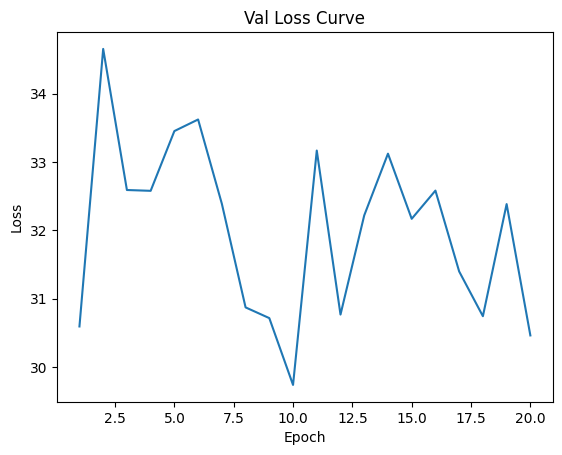

Student weights and architecture saved and exported for lambda: 5


In [26]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_rkd_wider_lambda02.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_rkd_wider_lambda02.pth'))
    teacher_model = teacher_model.to(device)
    
    # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights=None)
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)

    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_student)

    pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
    pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, epochs, lmda=i, patience=patience_student, optimizer_adv=student_optimizer_adv)

    torch.save(student_model.state_dict(), f'student_model_weights_rkd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_rkd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Update the dictionary with the student results
    if i in lambda_results:
        # If the key 'i' is already present in the dictionary
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })
    else:
        # If the key 'i' is not present in the dictionary
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }

In [38]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    inputs = inputs.to(device)

    teacher_time, student_time = 0, 0

    if teacher is not None:
        teacher = teacher.to(device)
        start_time = time.time()
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
        teacher_time = time.time() - start_time

    if student is not None:
        student = student.to(device)
        start_time = time.time()
        with torch.no_grad():
            student_outputs = student(inputs)
        student_time = time.time() - start_time
    
    return teacher_time, student_time


In [39]:
# # Loop through each lambda value
# lmda_list = lmda_list_student
# for lmda in lmda_list:
#     # Load teacher and student models for the current lambda
#     # teacher_model = torch.load(f'teacher_model_rkd_wider_lambda{lmda}.pth')
#     # student_model = torch.load(f'student_model_rkd_wider_lambda{lmda}.pth')

#     teacher_model = torch.load(f'teacher_model_rkd_wider_lambda02.pth')
#     student_model = torch.load(f'student_model_rkd_wider_lambda{lmda}.pth')


#     # Compute performance metrics
#     performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

#     # Compute model sizes and inference times
#     teacher_params, student_params = compare_model_size(teacher_model, student_model)
#     teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

#     # Update results for the current lambda value
#     if lmda in lambda_results:
#         lambda_results[lmda].update({
#             'performance_metrics': performance_metrics,
#             'teacher_params': teacher_params,
#             'student_params': student_params,
#             'teacher_time': teacher_time,
#             'student_time': student_time
#         })
#     else:
#         lambda_results[lmda] = {
#             'performance_metrics': performance_metrics,
#             'teacher_params': teacher_params,
#             'student_params': student_params,
#             'teacher_time': teacher_time,
#             'student_time': student_time
#         }


In [40]:
# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    for lmda_student in lmda_list_student:

        # Load the teacher model for the current lambda from the 'output_dir'
        # teacher_model_path = os.path.join(output_dir, f'teacher_model_rkd_wider_lambda{lmda_teacher}.pth')
        teacher_model_path =f'teacher_model_rkd_wider_lambda02.pth'
        teacher_model = torch.load(teacher_model_path)
        
        # Load the student model for the current lambda from the 'output_dir'
        # student_model_path = os.path.join(output_dir, f'student_model_rkd_wider_lambda{lmda_student}.pth')
        student_model_path = f'student_model_rkd_wider_lambda{lmda_student}.pth'
        student_model = torch.load(student_model_path)
    
        # Compute performance metrics
        performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    
        # Compute model sizes
        teacher_params, student_params = compare_model_size(teacher_model, student_model)
    
        # Construct a unique key for the current combination of lambda values
        lambda_key = (lmda_teacher, lmda_student)

        # Update results for the current lambda value
        if lambda_key in lambda_results:
            lambda_results[lambda_key].update({
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            })
        else:
            lambda_results[lambda_key] = {
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params
            }


(0, 0, 0) (0.5997113997113998, 0.5997113997113998, 0.5997113997113998)
(0, 3, 5) (0.4626262626262626, 0.35093795093795094, 0.4227994227994228)


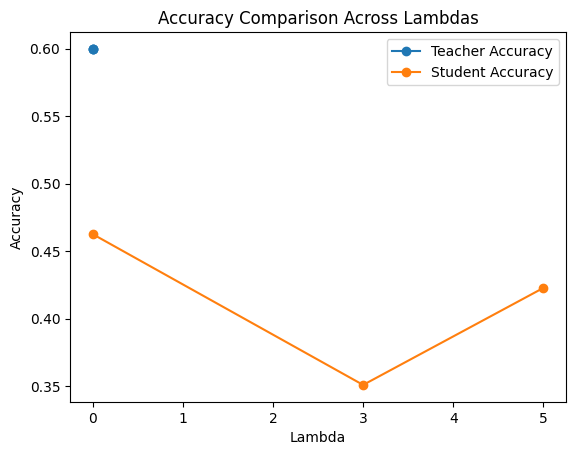

In [41]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

print(teacher_lambdas, teacher_acc)
print(student_lambdas, student_acc)
# Plotting
plt.plot(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.plot(student_lambdas, student_acc, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


(0, 0, 0) (0.6018209845490271, 0.6018209845490271, 0.6018209845490271)
(0, 3, 5) (0.47141829702175836, 0.39605600853778355, 0.4553643354028744)


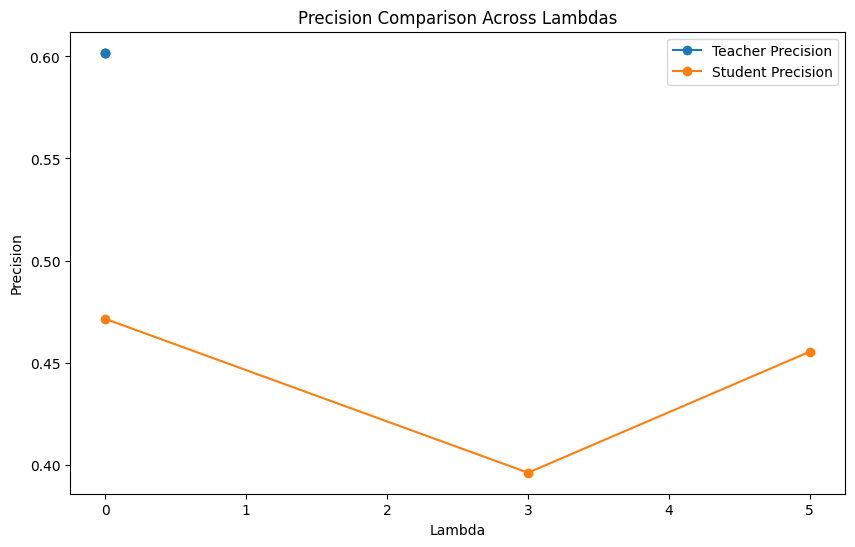

In [42]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# To plot, you might need to separate the lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

print(teacher_lambdas, teacher_prec)
print(student_lambdas, student_prec)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.plot(student_lambdas, student_prec, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


(0, 0, 0) (0.5997113997113998, 0.5997113997113998, 0.5997113997113998)
(0, 3, 5) (0.4626262626262626, 0.35093795093795094, 0.4227994227994228)


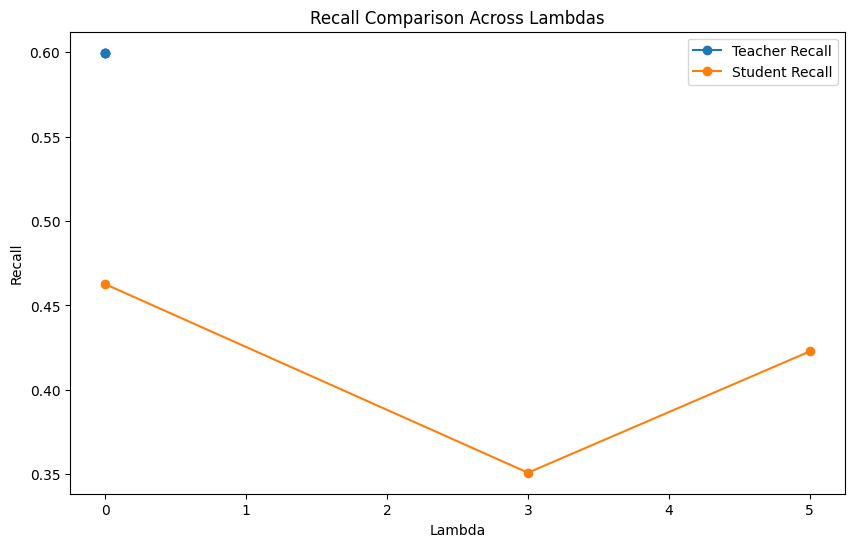

In [43]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# To plot, you might need to separate the lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

print(teacher_lambdas, teacher_rec)
print(student_lambdas, student_rec)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.plot(student_lambdas, student_rec, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()

(0, 0, 0) (0.5947508782046813, 0.5947508782046813, 0.5947508782046813)
(0, 3, 5) (0.4561321685037553, 0.3012299034033233, 0.4144215109184509)


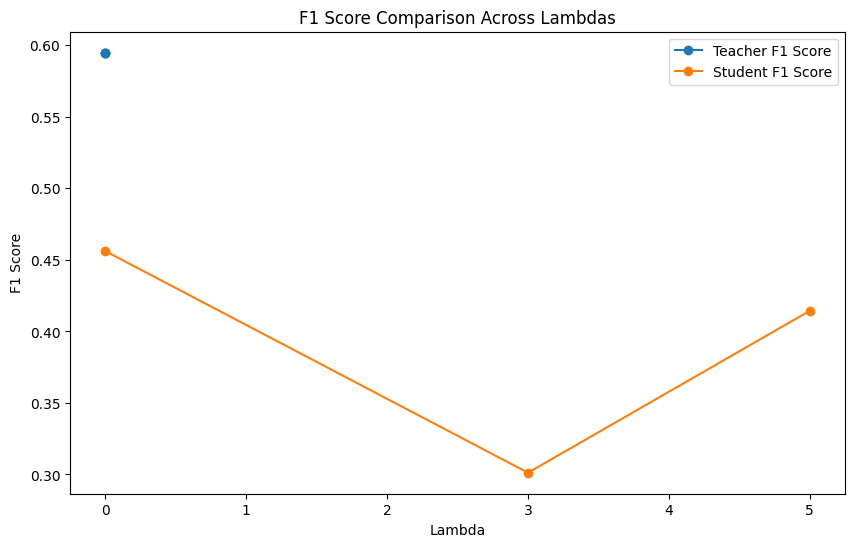

In [44]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# To plot, you might need to separate the lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

print(teacher_lambdas, teacher_f1_scores)
print(student_lambdas, student_f1_scores)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.plot(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()

(0, 0, 0) (10.720824, 10.720824, 10.720824)
(0, 3, 5) (4.028044, 4.028044, 4.028044)


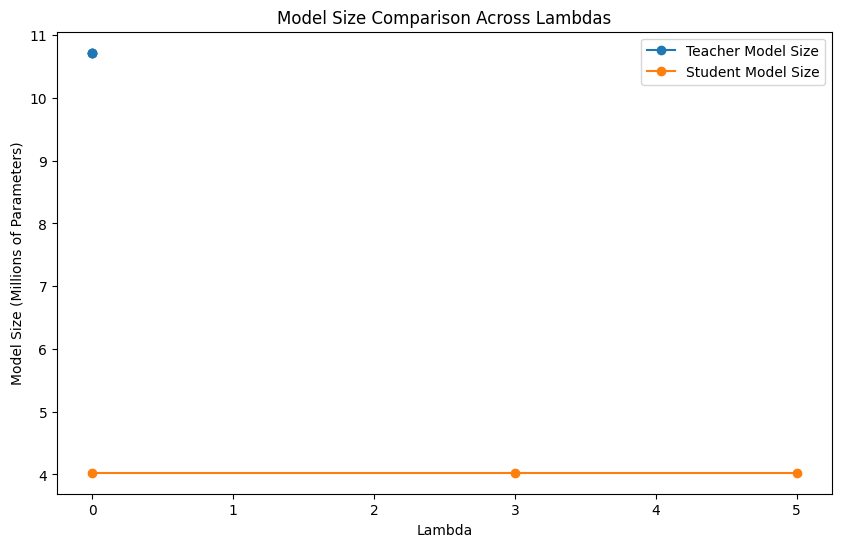

In [45]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# To plot, you might need to separate the lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

print(teacher_lambdas, teacher_model_sizes)
print(student_lambdas, student_model_sizes)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.plot(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()

(0,) (0.04833173751831055,)
(0, 3, 5) (0.04163050651550293, 0.018909215927124023, 0.03516817092895508)


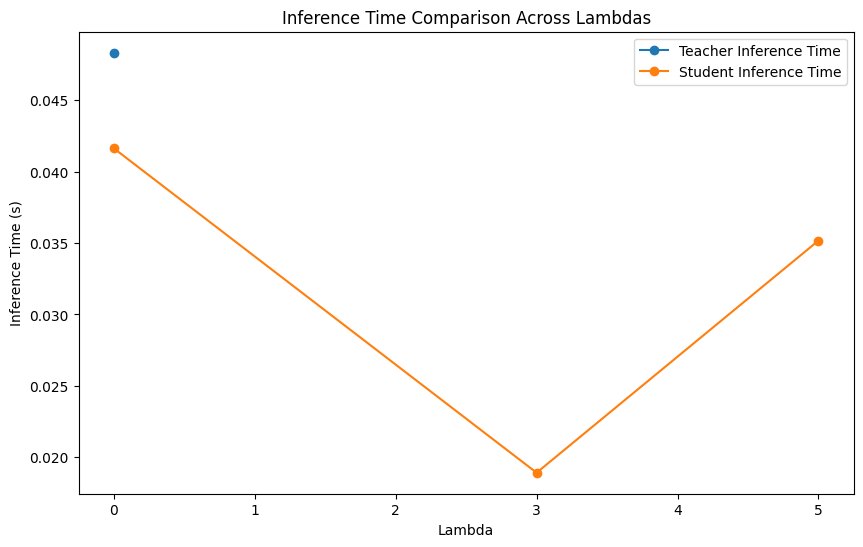

In [46]:
# Initialize dictionaries to store inference times for each lambda value
teacher_times = {}
student_times = {}

# Loop through each lambda value
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model for the current lambda
    # teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model_path = f'teacher_model_rkd_wider_lambda02.pth'
    teacher_model = torch.load(teacher_model_path)

    teacher_time, _ = compare_inference_time(teacher_model, None, testloader)
    teacher_times[lmda_teacher] = teacher_time  # Store the inference time for the teacher model

for lmda_student in lmda_list_student:
    # Load the student model for the current lambda
    # student_model_path = os.path.join(output_dir, f'student_model_rkd_wider_lambda{lmda_student}.pth')
    student_model_path = f'student_model_rkd_wider_lambda{lmda_student}.pth'
    student_model = torch.load(student_model_path)

    _, student_time = compare_inference_time(None, student_model, testloader)
    student_times[lmda_student] = student_time  # Store the inference time for the student model

# Prepare data for plotting
teacher_lambdas, teacher_inference_times = zip(*teacher_times.items())
student_lambdas, student_inference_times = zip(*student_times.items())

print(teacher_lambdas, teacher_inference_times )
print(student_lambdas, student_inference_times )

# plots
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.plot(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()

(0,) (0.12452049733518733,)
(0, 3, 5) (0.1673703545806974, 0.029996341267100473, 0.18848746200218758)


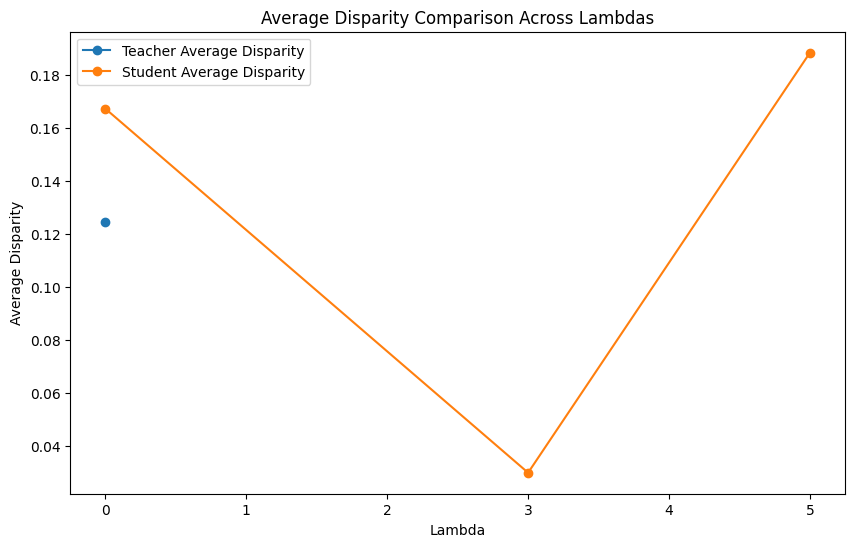

In [47]:
# Initialize lists to store disparity values
teacher_disparities = []
student_disparities = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if it's an integer key (indicating a lambda value for student)
    if isinstance(key, int):
        # Check and extract teacher disparity if it exists
        if 'teacher_mean_abs_val_disparity' in lambda_results[key]:
            teacher_disparity = lambda_results[key]['teacher_mean_abs_val_disparity']
            if isinstance(teacher_disparity, list):  # Assuming the disparity could be stored as a list
                teacher_disparity = teacher_disparity[0]
            teacher_disparities.append((key, teacher_disparity))

        # Extract student disparity
        if 'student_mean_abs_val_disparity' in lambda_results[key]:
            student_disparity = lambda_results[key]['student_mean_abs_val_disparity']
            student_disparities.append((key, student_disparity))

# Separate the lambda values and disparity values
teacher_lambdas, teacher_disparity_values = zip(*teacher_disparities) if teacher_disparities else ([], [])
student_lambdas, student_disparity_values = zip(*student_disparities) if student_disparities else ([], [])

print(teacher_lambdas, teacher_disparity_values)
print(student_lambdas, student_disparity_values)

# Plotting
plt.figure(figsize=(10, 6))
if teacher_disparities:
    plt.plot(teacher_lambdas, teacher_disparity_values, label='Teacher Average Disparity', marker='o')
if student_disparities:
    plt.plot(student_lambdas, student_disparity_values, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()

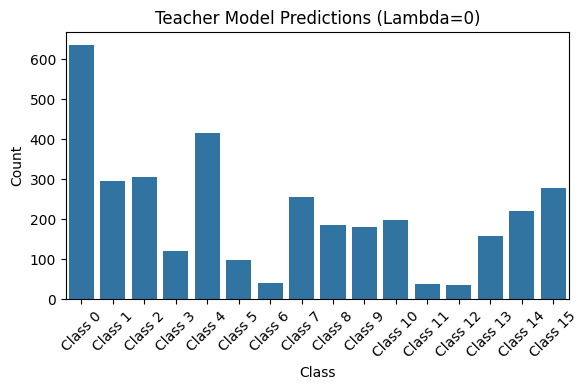

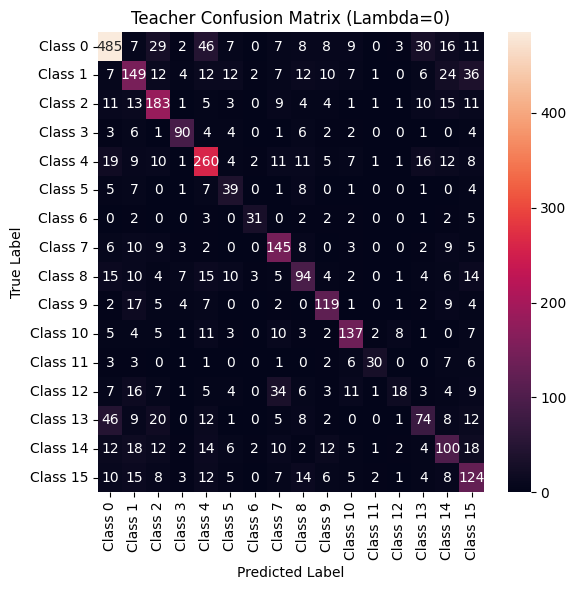

Classification Report - Teacher Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.76      0.73      0.74       668
     Class 1       0.51      0.50      0.50       301
     Class 2       0.60      0.67      0.63       272
     Class 3       0.74      0.73      0.73       124
     Class 4       0.62      0.69      0.66       377
     Class 5       0.40      0.53      0.45        74
     Class 6       0.78      0.62      0.69        50
     Class 7       0.57      0.72      0.63       202
     Class 8       0.51      0.48      0.49       194
     Class 9       0.66      0.69      0.67       173
    Class 10       0.69      0.69      0.69       199
    Class 11       0.77      0.50      0.61        60
    Class 12       0.49      0.14      0.22       129
    Class 13       0.47      0.37      0.41       198
    Class 14       0.45      0.45      0.45       220
    Class 15       0.45      0.55      0.49       224

    accuracy                   

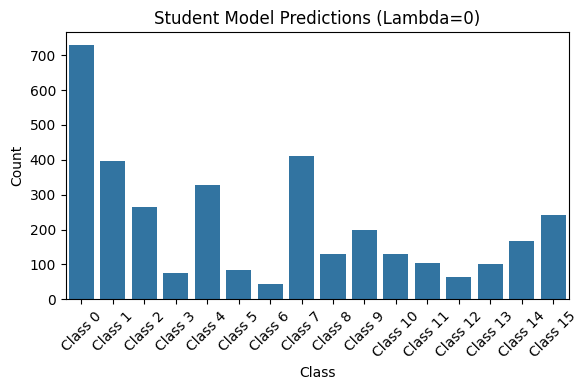

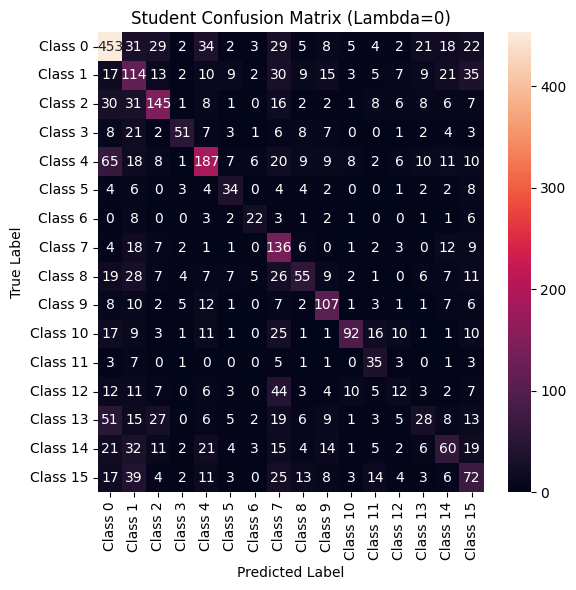

Classification Report - Student Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.62      0.68      0.65       668
     Class 1       0.29      0.38      0.33       301
     Class 2       0.55      0.53      0.54       272
     Class 3       0.66      0.41      0.51       124
     Class 4       0.57      0.50      0.53       377
     Class 5       0.41      0.46      0.43        74
     Class 6       0.50      0.44      0.47        50
     Class 7       0.33      0.67      0.44       202
     Class 8       0.43      0.28      0.34       194
     Class 9       0.54      0.62      0.58       173
    Class 10       0.71      0.46      0.56       199
    Class 11       0.34      0.58      0.43        60
    Class 12       0.19      0.09      0.12       129
    Class 13       0.28      0.14      0.19       198
    Class 14       0.36      0.27      0.31       220
    Class 15       0.30      0.32      0.31       224

    accuracy                   

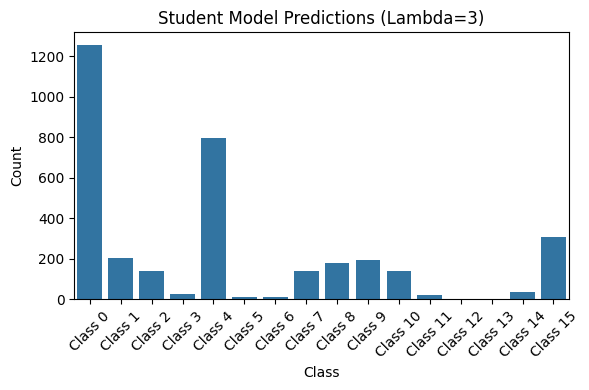

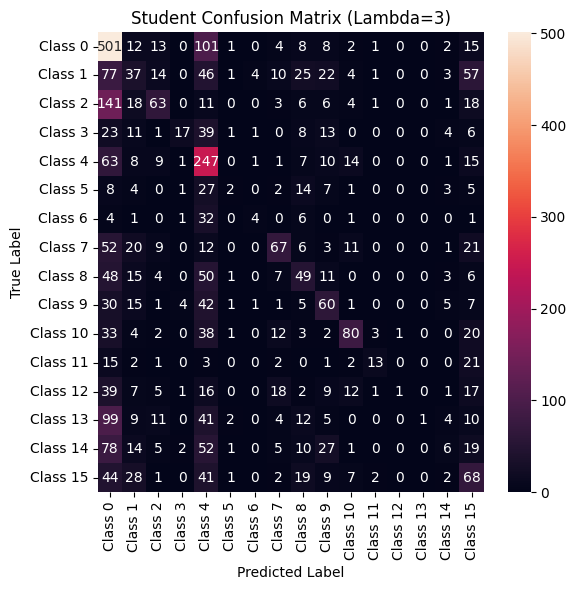

Classification Report - Student Model (Lambda=3)
              precision    recall  f1-score   support

     Class 0       0.40      0.75      0.52       668
     Class 1       0.18      0.12      0.15       301
     Class 2       0.45      0.23      0.31       272
     Class 3       0.63      0.14      0.23       124
     Class 4       0.31      0.66      0.42       377
     Class 5       0.17      0.03      0.05        74
     Class 6       0.36      0.08      0.13        50
     Class 7       0.49      0.33      0.39       202
     Class 8       0.27      0.25      0.26       194
     Class 9       0.31      0.35      0.33       173
    Class 10       0.57      0.40      0.47       199
    Class 11       0.59      0.22      0.32        60
    Class 12       0.50      0.01      0.02       129
    Class 13       1.00      0.01      0.01       198
    Class 14       0.17      0.03      0.05       220
    Class 15       0.22      0.30      0.26       224

    accuracy                   

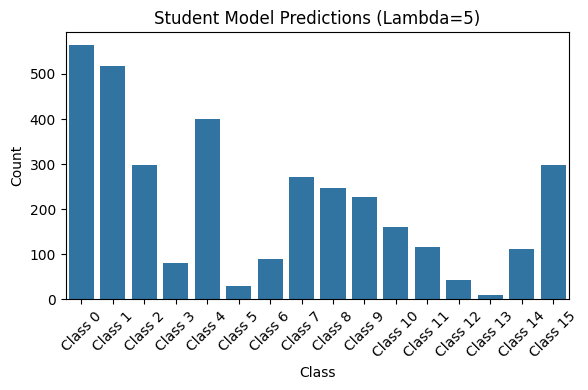

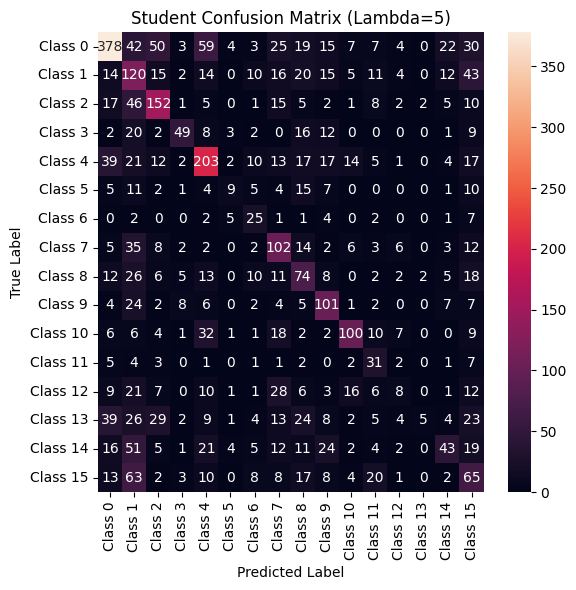

Classification Report - Student Model (Lambda=5)
              precision    recall  f1-score   support

     Class 0       0.67      0.57      0.61       668
     Class 1       0.23      0.40      0.29       301
     Class 2       0.51      0.56      0.53       272
     Class 3       0.61      0.40      0.48       124
     Class 4       0.51      0.54      0.52       377
     Class 5       0.30      0.12      0.17        74
     Class 6       0.28      0.50      0.36        50
     Class 7       0.38      0.50      0.43       202
     Class 8       0.30      0.38      0.33       194
     Class 9       0.44      0.58      0.50       173
    Class 10       0.62      0.50      0.56       199
    Class 11       0.27      0.52      0.35        60
    Class 12       0.19      0.06      0.09       129
    Class 13       0.56      0.03      0.05       198
    Class 14       0.38      0.20      0.26       220
    Class 15       0.22      0.29      0.25       224

    accuracy                   

In [48]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model from the 'output_dir'
    # teacher_model_path = os.path.join(output_dir, f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
    teacher_model_path = f'teacher_model_rkd_wider_lambda02.pth'
    teacher_model = torch.load(teacher_model_path)

    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in lmda_list_student:
    # Load the student model from the 'output_dir'
    # student_model_path = os.path.join(output_dir, f'student_model_ckd_wider_lambda{lmda_student}.pth')
    student_model_path = f'student_model_rkd_wider_lambda{lmda_student}.pth'
    student_model = torch.load(student_model_path)

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)

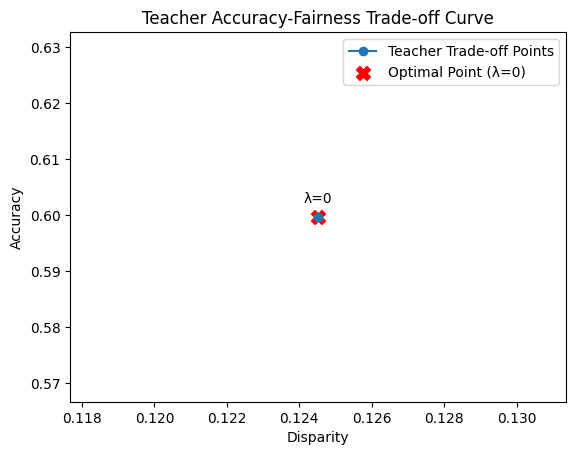

Optimal Lambda for Teacher: 0
Optimal Bias/Disparity for Teacher: 0.12452049733518733
Optimal Accuracy for Teacher: 0.5997113997113998
Optimal Weighted Ratio for Teacher: 0.53


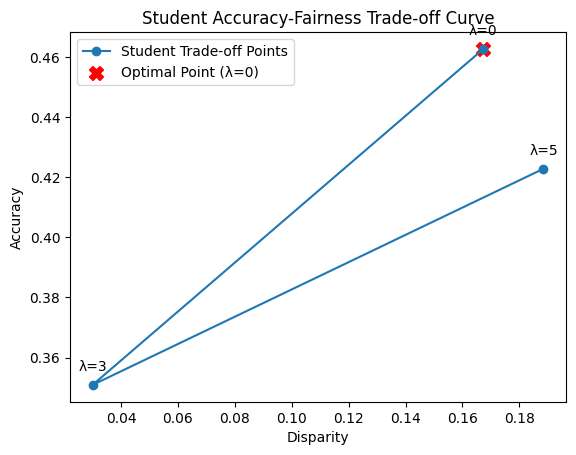

Optimal Lambda for Student: 0
Optimal Bias/Disparity for Student: 0.1673703545806974
Optimal Accuracy for Student: 0.4626262626262626
Optimal Weighted Ratio for Student: 0.40


In [49]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")


    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)


In [50]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info

In [51]:
def plot_images_with_details(info_list, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(rows * cols):
        if i < len(info_list):
            data = info_list[i]
            image = data['image']
            actual_class = data['actual_class']
            teacher_pred_class = data['teacher_pred_class']
            student_pred_class = data['student_pred_class']
            actual_attribute = round(data['actual_attribute'], 2)  # Round to 2 decimal places

            # Normalize the image for display
            image_display = image.cpu().numpy().transpose(1, 2, 0)
            image_display = (image_display - image_display.min()) / (image_display.max() - image_display.min())

            title = f'Actual: Class {actual_class}, Attr {actual_attribute}\n' + \
                    f'Teacher: Class {teacher_pred_class}\n' + \
                    f'Student: Class {student_pred_class}'

            axes[i].imshow(image_display)
            axes[i].set_title(title)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()


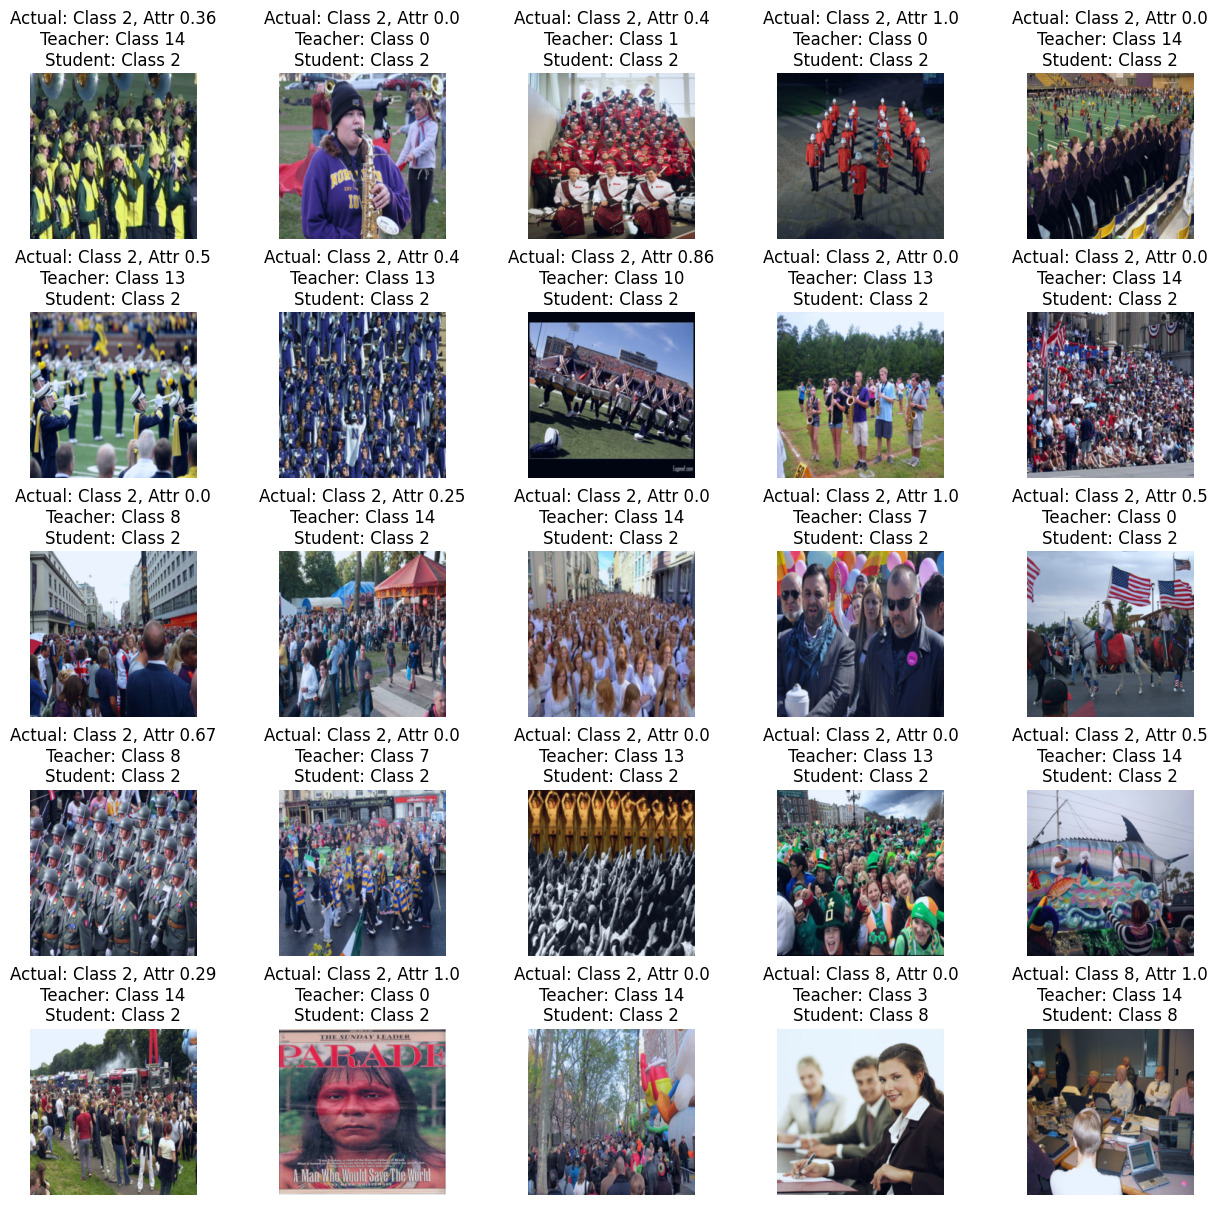

In [52]:
# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

# Display images with details
plot_images_with_details(detailed_info)